## Creating a PyTorch CNN ADT model

## Loading and preprocessing the data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchvision
import torch_audiomentations
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import os
import csv
import random

The `n_fft` variable affects the n_fft parameter used in generating melspectrograms and MFCC features used in training and validation. I found the value of `1024` works best, but `2048` can also work well.

In [2]:
dataset_name = "HeartsOnFireDS-v.1.0.3"
n_fft = 1024

df = pd.read_csv(os.path.join(dataset_name, "master.csv"))
train_df = pd.DataFrame()
valid_df = pd.DataFrame()

for idx, row in df.iterrows():
    onsets_path = row['onsets']
    onsets_df = pd.read_csv(onsets_path)
    train_onsets = onsets_df[onsets_df['split'] == 'training']
    valid_onsets = onsets_df[onsets_df['split'] == 'validation']
    
    # Append to respective dataframes
    train_df = pd.concat([train_df, train_onsets], ignore_index=True)
    valid_df = pd.concat([valid_df, valid_onsets], ignore_index=True)

train_df

,Unnamed: 0,onset_time,kick,snare,hihat,tom,crash,ride,other,name,changed,split,click,uncertain
0,0.0,45.429841,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
1,1.0,45.615601,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
2,3.0,45.952290,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
3,4.0,46.114830,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
4,5.0,46.288980,False,True,True,True,False,False,False,Crystallion - Eternia,True,training,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,856.0,208.735782,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5598,857.0,208.979592,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5599,858.0,209.142132,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN
5600,859.0,209.235011,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,NaN,NaN


### Setting custom weights based on the amount of classes in dataset

Also possible to alter the weight of the cymbal classes to force the model to be more accurate at classifying them.

In [3]:
counts = train_df.select_dtypes(include=bool).sum(axis=0)
counts = counts.drop(['other', 'changed'])
weights = counts.sum() / (counts * len(counts))
weights_tensor = torch.Tensor(list(weights.values))
#weights_tensor[2] = 1.0 # giving extra weight to the hihat class
weights_tensor

tensor([0.4488, 0.7198, 0.6256, 3.3700, 2.6250, 9.4111])

### Defining the dataset class with a custom transform pipeline

Note the `torch_audiomentations` transforms are implemented differently than the rest of the transforms, requiring the input tensors to be 4D: `[batch, num_channels, freq, time]`. Since we only have a 2D tensor of `[freq, time]`, we will add the extra dimensions and then remove them after we added the necessary data augmentation transforms. 

Bit of a cheaty solution, but I found this method performs the fastest if performed within the transform pipeline.

In [74]:
train_transform_mfccs = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    # torchvision.transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
    # torch_audiomentations.AddColoredNoise(
    #             min_snr_in_db=3,
    #             max_snr_in_db=30,
    #             sample_rate=44100,
    #             p=0.5,
    #             output_type='tensor'
    #         ).to("cuda"),
    # torch_audiomentations.Shift(
    #         min_shift=-0.15,
    #         max_shift=0.15,
    #         rollover=False,
    #         p=0.5,
    #         sample_rate=44100,
    #         output_type='tensor'
    #     ).to("cuda"),
    # torch_audiomentations.PitchShift(
    #         min_transpose_semitones=-1,
    #         max_transpose_semitones=1,
    #         p=0.25,
    #         sample_rate=44100,
    #         output_type='tensor'
    #     ).to("cuda"),
    # torch_audiomentations.Gain(p=0.5, output_type='tensor').to("cuda"),
    # torchvision.transforms.Lambda(lambda x: x.squeeze(0).squeeze(0)),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
            torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}
            ).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu")),
])

valid_transform_mfccs = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
    torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu"))
])

fast_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x)
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu"))
])

In [80]:
drum_labels = ['kick', 'snare', 'hihat', 'tom', 'crash', 'ride']

class DrumDataset(Dataset):
    def __init__(self, df, master_csv_path, transform, window_size=8192):
        self.df = df
        self.master_df = pd.read_csv(master_csv_path)
        self.window_size = window_size
        self.transform = transform
        self.audio_cache = {}

        for i, row in self.master_df.iterrows():
            audio_path = row['drums']
            audio, sr = torchaudio.load(audio_path, format="mp3")
            if audio.shape[0] == 2:
                audio = torch.mean(audio, dim=0, keepdim=True)
            self.audio_cache[row['name']] = (audio, sr)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        onset_time = row['onset_time']
        labels = row[drum_labels].astype(int).values.flatten()
        labels = torch.tensor(labels).float()
        track_name = row['name']
        #print(track_name, onset_time)

        audio = self.audio_cache[track_name][0]
        sr = self.audio_cache[track_name][1]

        onset_window = audio[:, int(onset_time*sr)-self.window_size//2:int(onset_time*sr)+self.window_size//2]
        spec = self.transform(onset_window[0])
        return spec, labels

valid_dataset = DrumDataset(valid_df, os.path.join(dataset_name, "master.csv"), fast_transform)
train_dataset = DrumDataset(train_df, os.path.join(dataset_name, "master.csv"), fast_transform)

### Getting a random onset and displaying the melspectrogram

4286 tensor([1., 0., 1., 0., 0., 0.])


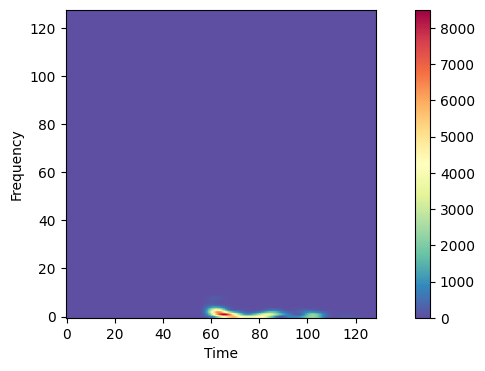

In [81]:
rand = random.randint(1, len(train_df))
a, x = train_dataset.__getitem__(rand)
specgram = a[1].detach().squeeze(0).numpy()
print(rand, x)

plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
#477 

## Defining the model architecture

### Model A

**Initial filter size:** `16`

In [82]:
# Define the neural network architecture
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1) # input channels
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

device = torch.device('cuda')

### Model B

**Initial filter size:** `32`

Thought about increasing the initial filter size to help with identifying hi-hats, performance is worse by 2-4% compared to Model A. Only run the following cell if you want to override Model A.

In [5]:
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

## Training

### Hyperparameters

In [96]:
n_epochs = 800
learning_rate = 0.001
batch_size = 16

### Loss function, optimizer, scheduler

In [97]:
def accuracy(outputs, labels, threshold=0.0):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the neural network and optimizer
model = DrumCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
start_epoch = 0
valid_loss = 0.0

# Define the loss function
criterion = nn.BCEWithLogitsLoss(weight=weights_tensor.to(device))

### Loading previous checkpoint to continue training

In [99]:
saved_model_dict = torch.load('models/HeartsOnFire-v.1.0.3_nfft1024_nomfcc_89.47.pth', map_location=device)
model.load_state_dict(saved_model_dict['model'])
scheduler.load_state_dict(saved_model_dict['scheduler'])
optimizer.load_state_dict(saved_model_dict['optimizer'])
start_epoch = saved_model_dict['epoch']
n_epochs += start_epoch+1

### Main loop

In [100]:
max_acc = 89.47

for epoch in range(start_epoch, n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=len(train_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    # Evaluate the model on the validation set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(valid_loader, total=len(valid_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Validation")):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend((outputs.cpu() > 0.0).float().numpy().tolist())
        valid_loss /= len(valid_loader.dataset)
        valid_acc /= len(valid_loader.dataset)

        cm = multilabel_confusion_matrix(true_labels, predicted_labels)
        f, axes = plt.subplots(1, 6, figsize=(25, 6))
        axes = axes.ravel()
        for i in range(len(drum_labels)):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=axes[i], values_format='.4g')
            disp.ax_.set_title(drum_labels[i])
            disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.1)
        f.colorbar(disp.im_, ax=axes)
        plt.savefig(f'cm_e{epoch+1}.png')
        plt.close()
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    tqdm.write(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

    if valid_acc > max_acc:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch
        }
        max_acc = valid_acc
        torch.save(checkpoint, f'models/{dataset_name}_nfft1024_nomfcc_{valid_acc:.2f}.pth')

Epoch 84/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.58batch/s]


Epoch 84/884, Train Loss: 0.0441, Train Acc: 89.47%, Valid Loss: 0.1110, Valid Acc: 88.26%


Epoch 85/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.75batch/s]


Epoch 85/884, Train Loss: 0.0476, Train Acc: 89.16%, Valid Loss: 0.1083, Valid Acc: 88.26%


Epoch 86/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.91batch/s]


Epoch 86/884, Train Loss: 0.0463, Train Acc: 89.38%, Valid Loss: 0.1129, Valid Acc: 88.05%


Epoch 87/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 87/884, Train Loss: 0.0448, Train Acc: 89.59%, Valid Loss: 0.1196, Valid Acc: 87.41%


Epoch 88/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.60batch/s]


Epoch 88/884, Train Loss: 0.0442, Train Acc: 89.40%, Valid Loss: 0.1103, Valid Acc: 88.48%


Epoch 89/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.78batch/s]


Epoch 89/884, Train Loss: 0.0463, Train Acc: 89.13%, Valid Loss: 0.1115, Valid Acc: 89.12%


Epoch 90/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.67batch/s]


Epoch 90/884, Train Loss: 0.0436, Train Acc: 90.09%, Valid Loss: 0.1069, Valid Acc: 89.26%


Epoch 91/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.80batch/s]


Epoch 91/884, Train Loss: 0.0449, Train Acc: 89.27%, Valid Loss: 0.1109, Valid Acc: 88.48%


Epoch 92/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.83batch/s]
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x000001B00C403D00>
Traceback (most recent call last):
  File "C:\Users\pdimo\AppData\Local\Programs\Python\Python310\lib\weakref.py", line 61, in _cb
    callback(self)
  File "c:\Work\Final Project\HeartsOnFire\.venv\lib\site-packages\matplotlib\cbook\__init__.py", line 254, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


Epoch 92/884, Train Loss: 0.0464, Train Acc: 89.56%, Valid Loss: 0.1194, Valid Acc: 88.69%


Epoch 93/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.76batch/s]


Epoch 93/884, Train Loss: 0.0470, Train Acc: 88.91%, Valid Loss: 0.1108, Valid Acc: 88.83%


Epoch 94/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 94/884, Train Loss: 0.0470, Train Acc: 89.08%, Valid Loss: 0.1120, Valid Acc: 87.84%


Epoch 95/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.27batch/s]


Epoch 95/884, Train Loss: 0.0463, Train Acc: 89.29%, Valid Loss: 0.1159, Valid Acc: 88.90%


Epoch 96/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.76batch/s]


Epoch 96/884, Train Loss: 0.0452, Train Acc: 89.59%, Valid Loss: 0.1198, Valid Acc: 88.34%


Epoch 97/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.70batch/s]


Epoch 97/884, Train Loss: 0.0465, Train Acc: 89.31%, Valid Loss: 0.1119, Valid Acc: 88.12%


Epoch 98/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.79batch/s]


Epoch 98/884, Train Loss: 0.0470, Train Acc: 89.45%, Valid Loss: 0.1090, Valid Acc: 88.48%


Epoch 99/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.84batch/s]


Epoch 99/884, Train Loss: 0.0440, Train Acc: 89.59%, Valid Loss: 0.1078, Valid Acc: 89.19%


Epoch 100/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.70batch/s]


Epoch 100/884, Train Loss: 0.0463, Train Acc: 89.54%, Valid Loss: 0.1180, Valid Acc: 88.12%


Epoch 101/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.67batch/s]


Epoch 101/884, Train Loss: 0.0443, Train Acc: 90.02%, Valid Loss: 0.1100, Valid Acc: 89.12%


Epoch 102/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.98batch/s]


Epoch 102/884, Train Loss: 0.0475, Train Acc: 89.41%, Valid Loss: 0.1086, Valid Acc: 88.05%


Epoch 103/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.98batch/s]


Epoch 103/884, Train Loss: 0.0471, Train Acc: 89.70%, Valid Loss: 0.1075, Valid Acc: 89.26%


Epoch 104/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.94batch/s]


Epoch 104/884, Train Loss: 0.0499, Train Acc: 88.52%, Valid Loss: 0.1116, Valid Acc: 89.05%


Epoch 105/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.67batch/s]


Epoch 105/884, Train Loss: 0.0444, Train Acc: 89.75%, Valid Loss: 0.1113, Valid Acc: 89.12%


Epoch 106/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.66batch/s]


Epoch 106/884, Train Loss: 0.0485, Train Acc: 89.45%, Valid Loss: 0.1147, Valid Acc: 88.83%


Epoch 107/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.73batch/s]
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x000001B098D45D80>
Traceback (most recent call last):
  File "C:\Users\pdimo\AppData\Local\Programs\Python\Python310\lib\weakref.py", line 61, in _cb
    callback(self)
  File "c:\Work\Final Project\HeartsOnFire\.venv\lib\site-packages\matplotlib\cbook\__init__.py", line 254, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


Epoch 107/884, Train Loss: 0.0452, Train Acc: 89.58%, Valid Loss: 0.1139, Valid Acc: 89.47%


Epoch 108/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.93batch/s]


Epoch 108/884, Train Loss: 0.0514, Train Acc: 89.22%, Valid Loss: 0.1092, Valid Acc: 89.05%


Epoch 109/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.70batch/s]


Epoch 109/884, Train Loss: 0.0440, Train Acc: 89.56%, Valid Loss: 0.1080, Valid Acc: 88.69%


Epoch 110/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.74batch/s]


Epoch 110/884, Train Loss: 0.0464, Train Acc: 89.40%, Valid Loss: 0.1067, Valid Acc: 88.41%


Epoch 111/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 111/884, Train Loss: 0.0467, Train Acc: 89.38%, Valid Loss: 0.1075, Valid Acc: 89.26%


Epoch 112/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.71batch/s]


Epoch 112/884, Train Loss: 0.0461, Train Acc: 89.95%, Valid Loss: 0.1151, Valid Acc: 89.26%


Epoch 113/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.76batch/s]


Epoch 113/884, Train Loss: 0.0445, Train Acc: 89.41%, Valid Loss: 0.1110, Valid Acc: 88.34%


Epoch 114/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.60batch/s]


Epoch 114/884, Train Loss: 0.0467, Train Acc: 89.25%, Valid Loss: 0.1138, Valid Acc: 88.19%


Epoch 115/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.66batch/s]


Epoch 115/884, Train Loss: 0.0489, Train Acc: 88.40%, Valid Loss: 0.1126, Valid Acc: 89.19%


Epoch 116/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.71batch/s]


Epoch 116/884, Train Loss: 0.0484, Train Acc: 88.72%, Valid Loss: 0.1098, Valid Acc: 88.55%


Epoch 117/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.95batch/s]


Epoch 117/884, Train Loss: 0.0441, Train Acc: 89.72%, Valid Loss: 0.1186, Valid Acc: 87.91%


Epoch 118/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 118/884, Train Loss: 0.0461, Train Acc: 89.61%, Valid Loss: 0.1118, Valid Acc: 88.69%


Epoch 119/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 119/884, Train Loss: 0.0463, Train Acc: 89.49%, Valid Loss: 0.1124, Valid Acc: 87.70%


Epoch 120/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.10batch/s]


Epoch 120/884, Train Loss: 0.0456, Train Acc: 88.88%, Valid Loss: 0.1131, Valid Acc: 88.98%


Epoch 121/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.79batch/s]


Epoch 121/884, Train Loss: 0.0474, Train Acc: 88.95%, Valid Loss: 0.1105, Valid Acc: 89.05%


Epoch 122/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 122/884, Train Loss: 0.0447, Train Acc: 89.83%, Valid Loss: 0.1114, Valid Acc: 88.55%


Epoch 123/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.60batch/s]


Epoch 123/884, Train Loss: 0.0451, Train Acc: 89.81%, Valid Loss: 0.1127, Valid Acc: 89.12%


Epoch 124/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.60batch/s]


Epoch 124/884, Train Loss: 0.0448, Train Acc: 89.81%, Valid Loss: 0.1156, Valid Acc: 88.26%


Epoch 125/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.61batch/s]


Epoch 125/884, Train Loss: 0.0459, Train Acc: 89.75%, Valid Loss: 0.1084, Valid Acc: 89.19%


Epoch 126/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.76batch/s]


Epoch 126/884, Train Loss: 0.0461, Train Acc: 89.27%, Valid Loss: 0.1123, Valid Acc: 88.55%


Epoch 127/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 127/884, Train Loss: 0.0486, Train Acc: 89.59%, Valid Loss: 0.1105, Valid Acc: 88.83%


Epoch 128/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.14batch/s]


Epoch 128/884, Train Loss: 0.0475, Train Acc: 89.22%, Valid Loss: 0.1104, Valid Acc: 88.26%


Epoch 129/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.69batch/s]


Epoch 129/884, Train Loss: 0.0443, Train Acc: 89.72%, Valid Loss: 0.1157, Valid Acc: 89.12%


Epoch 130/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 130/884, Train Loss: 0.0455, Train Acc: 89.77%, Valid Loss: 0.1105, Valid Acc: 88.69%


Epoch 131/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 131/884, Train Loss: 0.0435, Train Acc: 89.66%, Valid Loss: 0.1139, Valid Acc: 89.05%


Epoch 132/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.33batch/s]


Epoch 132/884, Train Loss: 0.0448, Train Acc: 89.40%, Valid Loss: 0.1054, Valid Acc: 88.98%


Epoch 133/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.31batch/s]


Epoch 133/884, Train Loss: 0.0431, Train Acc: 89.31%, Valid Loss: 0.1095, Valid Acc: 88.83%


Epoch 134/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.05batch/s]


Epoch 134/884, Train Loss: 0.0462, Train Acc: 89.81%, Valid Loss: 0.1208, Valid Acc: 87.84%


Epoch 135/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.78batch/s]


Epoch 135/884, Train Loss: 0.0486, Train Acc: 88.68%, Valid Loss: 0.1198, Valid Acc: 88.26%


Epoch 136/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.58batch/s]


Epoch 136/884, Train Loss: 0.0455, Train Acc: 89.29%, Valid Loss: 0.1077, Valid Acc: 89.33%


Epoch 137/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.31batch/s]


Epoch 137/884, Train Loss: 0.0465, Train Acc: 90.15%, Valid Loss: 0.1093, Valid Acc: 88.62%


Epoch 138/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.87batch/s]


Epoch 138/884, Train Loss: 0.0434, Train Acc: 90.40%, Valid Loss: 0.1082, Valid Acc: 88.83%


Epoch 139/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.68batch/s]


Epoch 139/884, Train Loss: 0.0473, Train Acc: 88.86%, Valid Loss: 0.1099, Valid Acc: 88.69%


Epoch 140/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 140/884, Train Loss: 0.0444, Train Acc: 89.33%, Valid Loss: 0.1145, Valid Acc: 88.62%


Epoch 141/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.38batch/s]


Epoch 141/884, Train Loss: 0.0480, Train Acc: 89.31%, Valid Loss: 0.1101, Valid Acc: 89.19%


Epoch 142/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.03batch/s]


Epoch 142/884, Train Loss: 0.0477, Train Acc: 89.18%, Valid Loss: 0.1084, Valid Acc: 89.47%


Epoch 143/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 143/884, Train Loss: 0.0438, Train Acc: 89.50%, Valid Loss: 0.1093, Valid Acc: 88.83%


Epoch 144/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 144/884, Train Loss: 0.0449, Train Acc: 88.95%, Valid Loss: 0.1090, Valid Acc: 88.26%


Epoch 145/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.93batch/s]


Epoch 145/884, Train Loss: 0.0498, Train Acc: 89.61%, Valid Loss: 0.1112, Valid Acc: 89.19%


Epoch 146/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.83batch/s]


Epoch 146/884, Train Loss: 0.0461, Train Acc: 89.97%, Valid Loss: 0.1099, Valid Acc: 88.26%


Epoch 147/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.37batch/s]


Epoch 147/884, Train Loss: 0.0481, Train Acc: 89.41%, Valid Loss: 0.1185, Valid Acc: 88.05%


Epoch 148/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.70batch/s]


Epoch 148/884, Train Loss: 0.0467, Train Acc: 89.11%, Valid Loss: 0.1153, Valid Acc: 88.34%


Epoch 149/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 149/884, Train Loss: 0.0461, Train Acc: 89.41%, Valid Loss: 0.1094, Valid Acc: 89.19%


Epoch 150/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 150/884, Train Loss: 0.0463, Train Acc: 89.75%, Valid Loss: 0.1097, Valid Acc: 89.19%


Epoch 151/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 151/884, Train Loss: 0.0460, Train Acc: 88.84%, Valid Loss: 0.1187, Valid Acc: 88.83%


Epoch 152/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 152/884, Train Loss: 0.0433, Train Acc: 89.90%, Valid Loss: 0.1137, Valid Acc: 88.69%


Epoch 153/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 153/884, Train Loss: 0.0443, Train Acc: 89.65%, Valid Loss: 0.1138, Valid Acc: 89.12%


Epoch 154/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.60batch/s]


Epoch 154/884, Train Loss: 0.0451, Train Acc: 89.52%, Valid Loss: 0.1082, Valid Acc: 88.41%


Epoch 155/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.81batch/s]


Epoch 155/884, Train Loss: 0.0453, Train Acc: 89.79%, Valid Loss: 0.1126, Valid Acc: 88.90%


Epoch 156/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.43batch/s]


Epoch 156/884, Train Loss: 0.0446, Train Acc: 89.38%, Valid Loss: 0.1123, Valid Acc: 87.98%


Epoch 157/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.19batch/s]


Epoch 157/884, Train Loss: 0.0468, Train Acc: 89.52%, Valid Loss: 0.1093, Valid Acc: 88.62%


Epoch 158/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.14batch/s]


Epoch 158/884, Train Loss: 0.0444, Train Acc: 89.16%, Valid Loss: 0.1123, Valid Acc: 88.48%


Epoch 159/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.69batch/s]


Epoch 159/884, Train Loss: 0.0459, Train Acc: 89.08%, Valid Loss: 0.1121, Valid Acc: 88.69%


Epoch 160/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.94batch/s]


Epoch 160/884, Train Loss: 0.0471, Train Acc: 89.29%, Valid Loss: 0.1196, Valid Acc: 88.48%


Epoch 161/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.93batch/s]


Epoch 161/884, Train Loss: 0.0442, Train Acc: 89.81%, Valid Loss: 0.1080, Valid Acc: 88.83%


Epoch 162/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.98batch/s]


Epoch 162/884, Train Loss: 0.0454, Train Acc: 89.47%, Valid Loss: 0.1122, Valid Acc: 88.90%


Epoch 163/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.26batch/s]


Epoch 163/884, Train Loss: 0.0445, Train Acc: 89.43%, Valid Loss: 0.1142, Valid Acc: 87.84%


Epoch 164/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.70batch/s]


Epoch 164/884, Train Loss: 0.0465, Train Acc: 89.29%, Valid Loss: 0.1084, Valid Acc: 88.12%


Epoch 165/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.63batch/s]


Epoch 165/884, Train Loss: 0.0465, Train Acc: 89.25%, Valid Loss: 0.1130, Valid Acc: 88.62%


Epoch 166/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 166/884, Train Loss: 0.0482, Train Acc: 89.11%, Valid Loss: 0.1104, Valid Acc: 89.47%


Epoch 167/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.44batch/s]


Epoch 167/884, Train Loss: 0.0466, Train Acc: 89.36%, Valid Loss: 0.1235, Valid Acc: 87.27%


Epoch 168/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.87batch/s]


Epoch 168/884, Train Loss: 0.0449, Train Acc: 89.88%, Valid Loss: 0.1136, Valid Acc: 88.62%


Epoch 169/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 169/884, Train Loss: 0.0436, Train Acc: 89.38%, Valid Loss: 0.1128, Valid Acc: 88.48%


Epoch 170/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.16batch/s]


Epoch 170/884, Train Loss: 0.0457, Train Acc: 89.63%, Valid Loss: 0.1206, Valid Acc: 87.91%


Epoch 171/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.52batch/s]


Epoch 171/884, Train Loss: 0.0447, Train Acc: 89.99%, Valid Loss: 0.1098, Valid Acc: 87.62%


Epoch 172/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.03batch/s]


Epoch 172/884, Train Loss: 0.0455, Train Acc: 89.90%, Valid Loss: 0.1121, Valid Acc: 88.69%


Epoch 173/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 173/884, Train Loss: 0.0445, Train Acc: 89.50%, Valid Loss: 0.1167, Valid Acc: 88.41%


Epoch 174/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.70batch/s]


Epoch 174/884, Train Loss: 0.0439, Train Acc: 89.31%, Valid Loss: 0.1141, Valid Acc: 88.62%


Epoch 175/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.05batch/s]


Epoch 175/884, Train Loss: 0.0472, Train Acc: 90.15%, Valid Loss: 0.1099, Valid Acc: 88.26%


Epoch 176/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 176/884, Train Loss: 0.0452, Train Acc: 89.66%, Valid Loss: 0.1186, Valid Acc: 87.98%


Epoch 177/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.35batch/s]


Epoch 177/884, Train Loss: 0.0455, Train Acc: 90.07%, Valid Loss: 0.1124, Valid Acc: 88.48%


Epoch 178/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.68batch/s]


Epoch 178/884, Train Loss: 0.0475, Train Acc: 89.25%, Valid Loss: 0.1154, Valid Acc: 87.70%


Epoch 179/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 179/884, Train Loss: 0.0453, Train Acc: 89.72%, Valid Loss: 0.1088, Valid Acc: 89.19%


Epoch 180/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 180/884, Train Loss: 0.0443, Train Acc: 89.99%, Valid Loss: 0.1156, Valid Acc: 88.34%


Epoch 181/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.45batch/s]


Epoch 181/884, Train Loss: 0.0462, Train Acc: 89.25%, Valid Loss: 0.1077, Valid Acc: 89.05%


Epoch 182/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.97batch/s]


Epoch 182/884, Train Loss: 0.0467, Train Acc: 88.72%, Valid Loss: 0.1108, Valid Acc: 88.26%


Epoch 183/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 183/884, Train Loss: 0.0469, Train Acc: 89.08%, Valid Loss: 0.1125, Valid Acc: 87.70%


Epoch 184/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.61batch/s]


Epoch 184/884, Train Loss: 0.0443, Train Acc: 89.70%, Valid Loss: 0.1117, Valid Acc: 88.55%


Epoch 185/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.74batch/s]


Epoch 185/884, Train Loss: 0.0446, Train Acc: 89.54%, Valid Loss: 0.1173, Valid Acc: 89.19%


Epoch 186/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 186/884, Train Loss: 0.0439, Train Acc: 90.13%, Valid Loss: 0.1112, Valid Acc: 88.76%


Epoch 187/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 187/884, Train Loss: 0.0461, Train Acc: 89.38%, Valid Loss: 0.1100, Valid Acc: 87.27%


Epoch 188/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.80batch/s]


Epoch 188/884, Train Loss: 0.0442, Train Acc: 89.22%, Valid Loss: 0.1069, Valid Acc: 88.98%


Epoch 189/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.24batch/s]


Epoch 189/884, Train Loss: 0.0459, Train Acc: 89.27%, Valid Loss: 0.1055, Valid Acc: 88.98%


Epoch 190/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 190/884, Train Loss: 0.0446, Train Acc: 89.79%, Valid Loss: 0.1086, Valid Acc: 88.48%


Epoch 191/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 191/884, Train Loss: 0.0448, Train Acc: 89.43%, Valid Loss: 0.1095, Valid Acc: 88.83%


Epoch 192/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.69batch/s]


Epoch 192/884, Train Loss: 0.0482, Train Acc: 88.72%, Valid Loss: 0.1158, Valid Acc: 88.69%


Epoch 193/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.13batch/s]


Epoch 193/884, Train Loss: 0.0456, Train Acc: 89.41%, Valid Loss: 0.1108, Valid Acc: 88.90%


Epoch 194/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.88batch/s]


Epoch 194/884, Train Loss: 0.0441, Train Acc: 89.75%, Valid Loss: 0.1099, Valid Acc: 88.69%


Epoch 195/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.44batch/s]


Epoch 195/884, Train Loss: 0.0445, Train Acc: 90.06%, Valid Loss: 0.1125, Valid Acc: 88.98%


Epoch 196/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.32batch/s]


Epoch 196/884, Train Loss: 0.0443, Train Acc: 89.81%, Valid Loss: 0.1099, Valid Acc: 89.05%


Epoch 197/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.67batch/s]


Epoch 197/884, Train Loss: 0.0469, Train Acc: 89.41%, Valid Loss: 0.1102, Valid Acc: 88.83%


Epoch 198/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 198/884, Train Loss: 0.0472, Train Acc: 89.52%, Valid Loss: 0.1082, Valid Acc: 88.12%


Epoch 199/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.63batch/s]


Epoch 199/884, Train Loss: 0.0457, Train Acc: 88.95%, Valid Loss: 0.1082, Valid Acc: 88.62%


Epoch 200/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 200/884, Train Loss: 0.0475, Train Acc: 88.79%, Valid Loss: 0.1133, Valid Acc: 87.70%


Epoch 201/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.42batch/s]


Epoch 201/884, Train Loss: 0.0451, Train Acc: 89.65%, Valid Loss: 0.1091, Valid Acc: 88.55%


Epoch 202/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.04batch/s]


Epoch 202/884, Train Loss: 0.0454, Train Acc: 89.77%, Valid Loss: 0.1106, Valid Acc: 87.70%


Epoch 203/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.68batch/s]


Epoch 203/884, Train Loss: 0.0464, Train Acc: 89.15%, Valid Loss: 0.1100, Valid Acc: 88.62%


Epoch 204/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.84batch/s]


Epoch 204/884, Train Loss: 0.0456, Train Acc: 89.33%, Valid Loss: 0.1140, Valid Acc: 88.55%


Epoch 205/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.51batch/s]


Epoch 205/884, Train Loss: 0.0456, Train Acc: 88.95%, Valid Loss: 0.1074, Valid Acc: 88.26%


Epoch 206/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 206/884, Train Loss: 0.0460, Train Acc: 89.08%, Valid Loss: 0.1159, Valid Acc: 89.26%


Epoch 207/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 207/884, Train Loss: 0.0464, Train Acc: 89.15%, Valid Loss: 0.1184, Valid Acc: 87.70%


Epoch 208/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 208/884, Train Loss: 0.0456, Train Acc: 89.45%, Valid Loss: 0.1098, Valid Acc: 88.48%


Epoch 209/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 209/884, Train Loss: 0.0463, Train Acc: 88.91%, Valid Loss: 0.1081, Valid Acc: 89.33%


Epoch 210/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.92batch/s]


Epoch 210/884, Train Loss: 0.0446, Train Acc: 89.59%, Valid Loss: 0.1133, Valid Acc: 89.47%


Epoch 211/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 211/884, Train Loss: 0.0451, Train Acc: 89.36%, Valid Loss: 0.1136, Valid Acc: 88.48%


Epoch 212/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.12batch/s]


Epoch 212/884, Train Loss: 0.0459, Train Acc: 89.40%, Valid Loss: 0.1137, Valid Acc: 87.98%


Epoch 213/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.54batch/s]


Epoch 213/884, Train Loss: 0.0469, Train Acc: 90.00%, Valid Loss: 0.1088, Valid Acc: 88.48%


Epoch 214/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.01batch/s]


Epoch 214/884, Train Loss: 0.0457, Train Acc: 89.52%, Valid Loss: 0.1129, Valid Acc: 87.98%


Epoch 215/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 215/884, Train Loss: 0.0456, Train Acc: 89.77%, Valid Loss: 0.1107, Valid Acc: 87.84%


Epoch 216/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.59batch/s]


Epoch 216/884, Train Loss: 0.0440, Train Acc: 89.99%, Valid Loss: 0.1115, Valid Acc: 89.40%


Epoch 217/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.59batch/s]


Epoch 217/884, Train Loss: 0.0465, Train Acc: 89.56%, Valid Loss: 0.1111, Valid Acc: 88.41%


Epoch 218/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.44batch/s]


Epoch 218/884, Train Loss: 0.0448, Train Acc: 89.15%, Valid Loss: 0.1082, Valid Acc: 88.12%


Epoch 219/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 219/884, Train Loss: 0.0456, Train Acc: 89.11%, Valid Loss: 0.1183, Valid Acc: 88.41%


Epoch 220/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 220/884, Train Loss: 0.0454, Train Acc: 89.29%, Valid Loss: 0.1076, Valid Acc: 89.05%


Epoch 221/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 221/884, Train Loss: 0.0472, Train Acc: 89.18%, Valid Loss: 0.1135, Valid Acc: 88.55%


Epoch 222/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.79batch/s]


Epoch 222/884, Train Loss: 0.0454, Train Acc: 90.34%, Valid Loss: 0.1121, Valid Acc: 88.62%


Epoch 223/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 223/884, Train Loss: 0.0459, Train Acc: 89.75%, Valid Loss: 0.1214, Valid Acc: 87.77%


Epoch 224/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 224/884, Train Loss: 0.0459, Train Acc: 89.11%, Valid Loss: 0.1118, Valid Acc: 89.26%


Epoch 225/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.35batch/s]


Epoch 225/884, Train Loss: 0.0427, Train Acc: 89.18%, Valid Loss: 0.1102, Valid Acc: 88.19%


Epoch 226/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.98batch/s]


Epoch 226/884, Train Loss: 0.0454, Train Acc: 89.66%, Valid Loss: 0.1111, Valid Acc: 89.26%


Epoch 227/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 227/884, Train Loss: 0.0449, Train Acc: 89.06%, Valid Loss: 0.1105, Valid Acc: 88.62%


Epoch 228/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.48batch/s]


Epoch 228/884, Train Loss: 0.0441, Train Acc: 89.75%, Valid Loss: 0.1110, Valid Acc: 88.98%


Epoch 229/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.52batch/s]


Epoch 229/884, Train Loss: 0.0457, Train Acc: 89.38%, Valid Loss: 0.1106, Valid Acc: 88.41%


Epoch 230/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.83batch/s]


Epoch 230/884, Train Loss: 0.0463, Train Acc: 89.24%, Valid Loss: 0.1105, Valid Acc: 89.33%


Epoch 231/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.61batch/s]


Epoch 231/884, Train Loss: 0.0443, Train Acc: 89.90%, Valid Loss: 0.1072, Valid Acc: 88.83%


Epoch 232/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 232/884, Train Loss: 0.0451, Train Acc: 89.43%, Valid Loss: 0.1219, Valid Acc: 88.62%


Epoch 233/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 233/884, Train Loss: 0.0453, Train Acc: 89.08%, Valid Loss: 0.1091, Valid Acc: 87.91%


Epoch 234/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.02batch/s]


Epoch 234/884, Train Loss: 0.0449, Train Acc: 89.41%, Valid Loss: 0.1103, Valid Acc: 88.48%


Epoch 235/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.98batch/s]


Epoch 235/884, Train Loss: 0.0460, Train Acc: 89.68%, Valid Loss: 0.1134, Valid Acc: 87.62%


Epoch 236/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.85batch/s]


Epoch 236/884, Train Loss: 0.0441, Train Acc: 88.95%, Valid Loss: 0.1094, Valid Acc: 88.55%


Epoch 237/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.37batch/s]


Epoch 237/884, Train Loss: 0.0445, Train Acc: 89.47%, Valid Loss: 0.1102, Valid Acc: 88.90%


Epoch 238/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 238/884, Train Loss: 0.0453, Train Acc: 89.74%, Valid Loss: 0.1129, Valid Acc: 88.34%


Epoch 239/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.46batch/s]


Epoch 239/884, Train Loss: 0.0466, Train Acc: 89.66%, Valid Loss: 0.1175, Valid Acc: 88.55%


Epoch 240/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.06batch/s]


Epoch 240/884, Train Loss: 0.0453, Train Acc: 89.79%, Valid Loss: 0.1112, Valid Acc: 88.55%


Epoch 241/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 241/884, Train Loss: 0.0455, Train Acc: 89.59%, Valid Loss: 0.1086, Valid Acc: 88.76%


Epoch 242/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.32batch/s]


Epoch 242/884, Train Loss: 0.0459, Train Acc: 88.61%, Valid Loss: 0.1141, Valid Acc: 89.19%


Epoch 243/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.91batch/s]


Epoch 243/884, Train Loss: 0.0484, Train Acc: 88.84%, Valid Loss: 0.1093, Valid Acc: 88.90%


Epoch 244/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.73batch/s]


Epoch 244/884, Train Loss: 0.0469, Train Acc: 89.00%, Valid Loss: 0.1123, Valid Acc: 87.91%


Epoch 245/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 245/884, Train Loss: 0.0455, Train Acc: 89.41%, Valid Loss: 0.1074, Valid Acc: 89.69%


Epoch 246/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.53batch/s]


Epoch 246/884, Train Loss: 0.0453, Train Acc: 89.79%, Valid Loss: 0.1136, Valid Acc: 88.62%


Epoch 247/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 247/884, Train Loss: 0.0460, Train Acc: 89.65%, Valid Loss: 0.1084, Valid Acc: 88.69%


Epoch 248/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.05batch/s]


Epoch 248/884, Train Loss: 0.0469, Train Acc: 89.66%, Valid Loss: 0.1257, Valid Acc: 87.62%


Epoch 249/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.48batch/s]


Epoch 249/884, Train Loss: 0.0474, Train Acc: 88.74%, Valid Loss: 0.1099, Valid Acc: 88.62%


Epoch 250/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 250/884, Train Loss: 0.0455, Train Acc: 89.31%, Valid Loss: 0.1129, Valid Acc: 88.12%


Epoch 251/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.43batch/s]


Epoch 251/884, Train Loss: 0.0466, Train Acc: 89.86%, Valid Loss: 0.1201, Valid Acc: 88.19%


Epoch 252/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 252/884, Train Loss: 0.0444, Train Acc: 89.38%, Valid Loss: 0.1224, Valid Acc: 86.98%


Epoch 253/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 253/884, Train Loss: 0.0453, Train Acc: 89.65%, Valid Loss: 0.1146, Valid Acc: 87.77%


Epoch 254/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.50batch/s]


Epoch 254/884, Train Loss: 0.0468, Train Acc: 90.06%, Valid Loss: 0.1279, Valid Acc: 88.12%


Epoch 255/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 255/884, Train Loss: 0.0439, Train Acc: 90.31%, Valid Loss: 0.1121, Valid Acc: 88.19%


Epoch 256/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.70batch/s]


Epoch 256/884, Train Loss: 0.0440, Train Acc: 89.72%, Valid Loss: 0.1156, Valid Acc: 88.76%


Epoch 257/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.05batch/s]


Epoch 257/884, Train Loss: 0.0453, Train Acc: 89.45%, Valid Loss: 0.1107, Valid Acc: 88.12%


Epoch 258/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.85batch/s]


Epoch 258/884, Train Loss: 0.0455, Train Acc: 90.07%, Valid Loss: 0.1115, Valid Acc: 88.62%


Epoch 259/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.54batch/s]


Epoch 259/884, Train Loss: 0.0474, Train Acc: 89.70%, Valid Loss: 0.1101, Valid Acc: 88.98%


Epoch 260/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.27batch/s]


Epoch 260/884, Train Loss: 0.0441, Train Acc: 89.11%, Valid Loss: 0.1103, Valid Acc: 88.69%


Epoch 261/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.64batch/s]


Epoch 261/884, Train Loss: 0.0443, Train Acc: 89.79%, Valid Loss: 0.1093, Valid Acc: 88.34%


Epoch 262/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.89batch/s]


Epoch 262/884, Train Loss: 0.0444, Train Acc: 90.34%, Valid Loss: 0.1104, Valid Acc: 87.98%


Epoch 263/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.00batch/s]


Epoch 263/884, Train Loss: 0.0464, Train Acc: 89.45%, Valid Loss: 0.1148, Valid Acc: 88.55%


Epoch 264/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.40batch/s]


Epoch 264/884, Train Loss: 0.0467, Train Acc: 89.36%, Valid Loss: 0.1281, Valid Acc: 88.55%


Epoch 265/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 265/884, Train Loss: 0.0457, Train Acc: 89.77%, Valid Loss: 0.1139, Valid Acc: 88.90%


Epoch 266/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.53batch/s]


Epoch 266/884, Train Loss: 0.0476, Train Acc: 89.33%, Valid Loss: 0.1165, Valid Acc: 88.90%


Epoch 267/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 267/884, Train Loss: 0.0488, Train Acc: 89.38%, Valid Loss: 0.1180, Valid Acc: 89.12%


Epoch 268/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.96batch/s]


Epoch 268/884, Train Loss: 0.0476, Train Acc: 89.33%, Valid Loss: 0.1084, Valid Acc: 88.05%


Epoch 269/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.44batch/s]


Epoch 269/884, Train Loss: 0.0468, Train Acc: 89.38%, Valid Loss: 0.1100, Valid Acc: 88.69%


Epoch 270/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 270/884, Train Loss: 0.0446, Train Acc: 89.38%, Valid Loss: 0.1147, Valid Acc: 87.84%


Epoch 271/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.78batch/s]


Epoch 271/884, Train Loss: 0.0460, Train Acc: 88.99%, Valid Loss: 0.1196, Valid Acc: 88.41%


Epoch 272/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.92batch/s]


Epoch 272/884, Train Loss: 0.0473, Train Acc: 89.61%, Valid Loss: 0.1125, Valid Acc: 89.05%


Epoch 273/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.35batch/s]


Epoch 273/884, Train Loss: 0.0466, Train Acc: 88.97%, Valid Loss: 0.1107, Valid Acc: 88.98%


Epoch 274/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.84batch/s]


Epoch 274/884, Train Loss: 0.0472, Train Acc: 89.22%, Valid Loss: 0.1112, Valid Acc: 88.19%


Epoch 275/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 275/884, Train Loss: 0.0495, Train Acc: 89.75%, Valid Loss: 0.1319, Valid Acc: 88.05%


Epoch 276/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.66batch/s]


Epoch 276/884, Train Loss: 0.0467, Train Acc: 88.56%, Valid Loss: 0.1096, Valid Acc: 89.33%


Epoch 277/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.65batch/s]


Epoch 277/884, Train Loss: 0.0436, Train Acc: 89.91%, Valid Loss: 0.1116, Valid Acc: 88.90%


Epoch 278/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.39batch/s]


Epoch 278/884, Train Loss: 0.0457, Train Acc: 89.59%, Valid Loss: 0.1078, Valid Acc: 89.05%


Epoch 279/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 279/884, Train Loss: 0.0451, Train Acc: 88.88%, Valid Loss: 0.1096, Valid Acc: 89.69%


Epoch 280/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 280/884, Train Loss: 0.0442, Train Acc: 89.63%, Valid Loss: 0.1097, Valid Acc: 89.40%


Epoch 281/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.97batch/s]


Epoch 281/884, Train Loss: 0.0467, Train Acc: 89.34%, Valid Loss: 0.1096, Valid Acc: 88.76%


Epoch 282/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.47batch/s]


Epoch 282/884, Train Loss: 0.0443, Train Acc: 90.04%, Valid Loss: 0.1108, Valid Acc: 87.98%


Epoch 283/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.47batch/s]


Epoch 283/884, Train Loss: 0.0457, Train Acc: 89.38%, Valid Loss: 0.1109, Valid Acc: 88.41%


Epoch 284/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.48batch/s]


Epoch 284/884, Train Loss: 0.0451, Train Acc: 89.13%, Valid Loss: 0.1138, Valid Acc: 88.90%


Epoch 285/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 285/884, Train Loss: 0.0471, Train Acc: 89.99%, Valid Loss: 0.1113, Valid Acc: 88.76%


Epoch 286/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.06batch/s]


Epoch 286/884, Train Loss: 0.0435, Train Acc: 90.18%, Valid Loss: 0.1158, Valid Acc: 88.62%


Epoch 287/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 287/884, Train Loss: 0.0436, Train Acc: 89.58%, Valid Loss: 0.1111, Valid Acc: 88.26%


Epoch 288/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.96batch/s]


Epoch 288/884, Train Loss: 0.0432, Train Acc: 89.50%, Valid Loss: 0.1178, Valid Acc: 88.62%


Epoch 289/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.98batch/s]


Epoch 289/884, Train Loss: 0.0476, Train Acc: 88.95%, Valid Loss: 0.1114, Valid Acc: 88.55%


Epoch 290/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 290/884, Train Loss: 0.0444, Train Acc: 89.99%, Valid Loss: 0.1057, Valid Acc: 89.12%


Epoch 291/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.51batch/s]


Epoch 291/884, Train Loss: 0.0460, Train Acc: 89.93%, Valid Loss: 0.1095, Valid Acc: 88.98%


Epoch 292/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 292/884, Train Loss: 0.0459, Train Acc: 89.36%, Valid Loss: 0.1126, Valid Acc: 88.90%


Epoch 293/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.91batch/s]


Epoch 293/884, Train Loss: 0.0450, Train Acc: 88.83%, Valid Loss: 0.1182, Valid Acc: 88.62%


Epoch 294/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.55batch/s]


Epoch 294/884, Train Loss: 0.0482, Train Acc: 89.04%, Valid Loss: 0.1237, Valid Acc: 88.19%


Epoch 295/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.08batch/s]


Epoch 295/884, Train Loss: 0.0475, Train Acc: 89.65%, Valid Loss: 0.1115, Valid Acc: 88.41%


Epoch 296/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.98batch/s]


Epoch 296/884, Train Loss: 0.0431, Train Acc: 90.13%, Valid Loss: 0.1089, Valid Acc: 88.48%


Epoch 297/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 297/884, Train Loss: 0.0476, Train Acc: 89.25%, Valid Loss: 0.1218, Valid Acc: 89.05%


Epoch 298/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 298/884, Train Loss: 0.0449, Train Acc: 89.58%, Valid Loss: 0.1090, Valid Acc: 89.26%


Epoch 299/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 299/884, Train Loss: 0.0478, Train Acc: 89.11%, Valid Loss: 0.1137, Valid Acc: 87.98%


Epoch 300/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 300/884, Train Loss: 0.0447, Train Acc: 89.66%, Valid Loss: 0.1116, Valid Acc: 89.19%


Epoch 301/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 301/884, Train Loss: 0.0446, Train Acc: 90.06%, Valid Loss: 0.1093, Valid Acc: 88.34%


Epoch 302/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.41batch/s]


Epoch 302/884, Train Loss: 0.0459, Train Acc: 89.97%, Valid Loss: 0.1133, Valid Acc: 88.55%


Epoch 303/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.88batch/s]


Epoch 303/884, Train Loss: 0.0458, Train Acc: 89.47%, Valid Loss: 0.1124, Valid Acc: 88.12%


Epoch 304/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.71batch/s]


Epoch 304/884, Train Loss: 0.0457, Train Acc: 89.47%, Valid Loss: 0.1144, Valid Acc: 88.26%


Epoch 305/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.38batch/s]


Epoch 305/884, Train Loss: 0.0468, Train Acc: 89.41%, Valid Loss: 0.1149, Valid Acc: 87.98%


Epoch 306/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.63batch/s]


Epoch 306/884, Train Loss: 0.0469, Train Acc: 89.20%, Valid Loss: 0.1086, Valid Acc: 88.98%


Epoch 307/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 307/884, Train Loss: 0.0460, Train Acc: 89.97%, Valid Loss: 0.1146, Valid Acc: 88.69%


Epoch 308/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.30batch/s]


Epoch 308/884, Train Loss: 0.0469, Train Acc: 89.20%, Valid Loss: 0.1114, Valid Acc: 88.48%


Epoch 309/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.61batch/s]


Epoch 309/884, Train Loss: 0.0458, Train Acc: 89.38%, Valid Loss: 0.1111, Valid Acc: 89.05%


Epoch 310/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 310/884, Train Loss: 0.0452, Train Acc: 89.34%, Valid Loss: 0.1180, Valid Acc: 88.19%


Epoch 311/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.53batch/s]


Epoch 311/884, Train Loss: 0.0447, Train Acc: 89.70%, Valid Loss: 0.1096, Valid Acc: 88.90%


Epoch 312/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 312/884, Train Loss: 0.0459, Train Acc: 89.72%, Valid Loss: 0.1128, Valid Acc: 88.55%


Epoch 313/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 313/884, Train Loss: 0.0465, Train Acc: 88.97%, Valid Loss: 0.1079, Valid Acc: 88.76%


Epoch 314/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.42batch/s]


Epoch 314/884, Train Loss: 0.0486, Train Acc: 88.90%, Valid Loss: 0.1145, Valid Acc: 89.05%


Epoch 315/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.23batch/s]


Epoch 315/884, Train Loss: 0.0448, Train Acc: 89.41%, Valid Loss: 0.1091, Valid Acc: 89.62%


Epoch 316/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.15batch/s]


Epoch 316/884, Train Loss: 0.0456, Train Acc: 89.70%, Valid Loss: 0.1113, Valid Acc: 87.70%


Epoch 317/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 317/884, Train Loss: 0.0476, Train Acc: 89.18%, Valid Loss: 0.1163, Valid Acc: 88.26%


Epoch 318/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 318/884, Train Loss: 0.0456, Train Acc: 89.36%, Valid Loss: 0.1101, Valid Acc: 88.19%


Epoch 319/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 319/884, Train Loss: 0.0431, Train Acc: 90.02%, Valid Loss: 0.1110, Valid Acc: 89.05%


Epoch 320/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.43batch/s]


Epoch 320/884, Train Loss: 0.0439, Train Acc: 89.70%, Valid Loss: 0.1113, Valid Acc: 89.26%


Epoch 321/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.81batch/s]


Epoch 321/884, Train Loss: 0.0461, Train Acc: 89.61%, Valid Loss: 0.1126, Valid Acc: 88.05%


Epoch 322/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.51batch/s]


Epoch 322/884, Train Loss: 0.0461, Train Acc: 89.65%, Valid Loss: 0.1119, Valid Acc: 88.55%


Epoch 323/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.23batch/s]


Epoch 323/884, Train Loss: 0.0442, Train Acc: 90.52%, Valid Loss: 0.1115, Valid Acc: 89.05%


Epoch 324/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.18batch/s]


Epoch 324/884, Train Loss: 0.0445, Train Acc: 89.54%, Valid Loss: 0.1083, Valid Acc: 88.90%


Epoch 325/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.91batch/s]


Epoch 325/884, Train Loss: 0.0446, Train Acc: 89.22%, Valid Loss: 0.1132, Valid Acc: 89.40%


Epoch 326/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.42batch/s]


Epoch 326/884, Train Loss: 0.0476, Train Acc: 89.56%, Valid Loss: 0.1149, Valid Acc: 88.05%


Epoch 327/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.61batch/s]


Epoch 327/884, Train Loss: 0.0455, Train Acc: 89.91%, Valid Loss: 0.1108, Valid Acc: 88.62%


Epoch 328/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.17batch/s]


Epoch 328/884, Train Loss: 0.0461, Train Acc: 89.20%, Valid Loss: 0.1068, Valid Acc: 88.48%


Epoch 329/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.92batch/s]


Epoch 329/884, Train Loss: 0.0479, Train Acc: 88.77%, Valid Loss: 0.1172, Valid Acc: 88.41%


Epoch 330/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.94batch/s]


Epoch 330/884, Train Loss: 0.0451, Train Acc: 89.59%, Valid Loss: 0.1143, Valid Acc: 89.47%


Epoch 331/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 331/884, Train Loss: 0.0465, Train Acc: 89.84%, Valid Loss: 0.1107, Valid Acc: 88.62%


Epoch 332/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.30batch/s]


Epoch 332/884, Train Loss: 0.0439, Train Acc: 89.59%, Valid Loss: 0.1100, Valid Acc: 88.62%


Epoch 333/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.79batch/s]


Epoch 333/884, Train Loss: 0.0434, Train Acc: 89.59%, Valid Loss: 0.1320, Valid Acc: 88.19%


Epoch 334/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.97batch/s]


Epoch 334/884, Train Loss: 0.0470, Train Acc: 88.93%, Valid Loss: 0.1076, Valid Acc: 89.12%


Epoch 335/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.32batch/s]


Epoch 335/884, Train Loss: 0.0476, Train Acc: 89.40%, Valid Loss: 0.1143, Valid Acc: 88.76%


Epoch 336/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 336/884, Train Loss: 0.0450, Train Acc: 89.33%, Valid Loss: 0.1099, Valid Acc: 88.98%


Epoch 337/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.39batch/s]


Epoch 337/884, Train Loss: 0.0467, Train Acc: 89.66%, Valid Loss: 0.1192, Valid Acc: 88.55%


Epoch 338/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.57batch/s]


Epoch 338/884, Train Loss: 0.0481, Train Acc: 89.83%, Valid Loss: 0.1066, Valid Acc: 88.62%


Epoch 339/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 339/884, Train Loss: 0.0432, Train Acc: 89.79%, Valid Loss: 0.1151, Valid Acc: 88.55%


Epoch 340/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 340/884, Train Loss: 0.0443, Train Acc: 89.15%, Valid Loss: 0.1110, Valid Acc: 88.83%


Epoch 341/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 341/884, Train Loss: 0.0472, Train Acc: 88.88%, Valid Loss: 0.1122, Valid Acc: 89.33%


Epoch 342/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.36batch/s]


Epoch 342/884, Train Loss: 0.0436, Train Acc: 89.65%, Valid Loss: 0.1105, Valid Acc: 89.12%


Epoch 343/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.18batch/s]


Epoch 343/884, Train Loss: 0.0461, Train Acc: 89.95%, Valid Loss: 0.1196, Valid Acc: 88.26%


Epoch 344/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.52batch/s]


Epoch 344/884, Train Loss: 0.0469, Train Acc: 89.08%, Valid Loss: 0.1134, Valid Acc: 88.12%


Epoch 345/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 345/884, Train Loss: 0.0485, Train Acc: 89.25%, Valid Loss: 0.1181, Valid Acc: 87.77%


Epoch 346/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 346/884, Train Loss: 0.0449, Train Acc: 90.18%, Valid Loss: 0.1071, Valid Acc: 89.05%


Epoch 347/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.79batch/s]


Epoch 347/884, Train Loss: 0.0453, Train Acc: 89.31%, Valid Loss: 0.1108, Valid Acc: 88.41%


Epoch 348/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.45batch/s]


Epoch 348/884, Train Loss: 0.0451, Train Acc: 89.47%, Valid Loss: 0.1103, Valid Acc: 87.84%


Epoch 349/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.95batch/s]


Epoch 349/884, Train Loss: 0.0460, Train Acc: 89.04%, Valid Loss: 0.1105, Valid Acc: 88.76%


Epoch 350/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.81batch/s]


Epoch 350/884, Train Loss: 0.0473, Train Acc: 89.63%, Valid Loss: 0.1227, Valid Acc: 88.19%


Epoch 351/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 351/884, Train Loss: 0.0470, Train Acc: 89.43%, Valid Loss: 0.1092, Valid Acc: 89.05%


Epoch 352/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 352/884, Train Loss: 0.0458, Train Acc: 89.41%, Valid Loss: 0.1107, Valid Acc: 88.90%


Epoch 353/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.35batch/s]


Epoch 353/884, Train Loss: 0.0457, Train Acc: 89.68%, Valid Loss: 0.1102, Valid Acc: 89.26%


Epoch 354/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 354/884, Train Loss: 0.0461, Train Acc: 89.49%, Valid Loss: 0.1103, Valid Acc: 88.90%


Epoch 355/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 355/884, Train Loss: 0.0463, Train Acc: 89.40%, Valid Loss: 0.1074, Valid Acc: 88.62%


Epoch 356/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.95batch/s]


Epoch 356/884, Train Loss: 0.0432, Train Acc: 89.49%, Valid Loss: 0.1096, Valid Acc: 88.41%


Epoch 357/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 357/884, Train Loss: 0.0476, Train Acc: 89.33%, Valid Loss: 0.1168, Valid Acc: 88.62%


Epoch 358/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.30batch/s]


Epoch 358/884, Train Loss: 0.0426, Train Acc: 89.95%, Valid Loss: 0.1119, Valid Acc: 89.19%


Epoch 359/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.40batch/s]


Epoch 359/884, Train Loss: 0.0444, Train Acc: 89.58%, Valid Loss: 0.1107, Valid Acc: 89.33%


Epoch 360/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.50batch/s]


Epoch 360/884, Train Loss: 0.0456, Train Acc: 89.27%, Valid Loss: 0.1072, Valid Acc: 88.62%


Epoch 361/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 361/884, Train Loss: 0.0460, Train Acc: 88.91%, Valid Loss: 0.1098, Valid Acc: 89.26%


Epoch 362/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 362/884, Train Loss: 0.0455, Train Acc: 89.15%, Valid Loss: 0.1147, Valid Acc: 88.62%


Epoch 363/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 363/884, Train Loss: 0.0460, Train Acc: 89.65%, Valid Loss: 0.1091, Valid Acc: 88.55%


Epoch 364/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 364/884, Train Loss: 0.0455, Train Acc: 89.61%, Valid Loss: 0.1065, Valid Acc: 88.90%


Epoch 365/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.40batch/s]


Epoch 365/884, Train Loss: 0.0468, Train Acc: 89.41%, Valid Loss: 0.1132, Valid Acc: 88.41%


Epoch 366/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.53batch/s]


Epoch 366/884, Train Loss: 0.0446, Train Acc: 89.79%, Valid Loss: 0.1088, Valid Acc: 88.76%


Epoch 367/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 367/884, Train Loss: 0.0453, Train Acc: 89.74%, Valid Loss: 0.1138, Valid Acc: 89.12%


Epoch 368/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.68batch/s]


Epoch 368/884, Train Loss: 0.0482, Train Acc: 89.63%, Valid Loss: 0.1170, Valid Acc: 88.69%


Epoch 369/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.44batch/s]


Epoch 369/884, Train Loss: 0.0456, Train Acc: 89.56%, Valid Loss: 0.1095, Valid Acc: 88.69%


Epoch 370/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 370/884, Train Loss: 0.0462, Train Acc: 88.97%, Valid Loss: 0.1183, Valid Acc: 88.62%


Epoch 371/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.34batch/s]


Epoch 371/884, Train Loss: 0.0453, Train Acc: 89.47%, Valid Loss: 0.1069, Valid Acc: 88.98%


Epoch 372/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 372/884, Train Loss: 0.0449, Train Acc: 89.72%, Valid Loss: 0.1058, Valid Acc: 89.69%


Epoch 373/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 373/884, Train Loss: 0.0454, Train Acc: 89.74%, Valid Loss: 0.1133, Valid Acc: 89.19%


Epoch 374/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.39batch/s]


Epoch 374/884, Train Loss: 0.0460, Train Acc: 89.59%, Valid Loss: 0.1093, Valid Acc: 88.48%


Epoch 375/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.01batch/s]


Epoch 375/884, Train Loss: 0.0459, Train Acc: 89.47%, Valid Loss: 0.1066, Valid Acc: 88.62%


Epoch 376/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 376/884, Train Loss: 0.0449, Train Acc: 89.83%, Valid Loss: 0.1143, Valid Acc: 87.91%


Epoch 377/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 377/884, Train Loss: 0.0468, Train Acc: 89.06%, Valid Loss: 0.1112, Valid Acc: 88.41%


Epoch 378/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 378/884, Train Loss: 0.0484, Train Acc: 89.22%, Valid Loss: 0.1121, Valid Acc: 88.55%


Epoch 379/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.37batch/s]


Epoch 379/884, Train Loss: 0.0486, Train Acc: 89.43%, Valid Loss: 0.1107, Valid Acc: 89.47%


Epoch 380/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.48batch/s]


Epoch 380/884, Train Loss: 0.0443, Train Acc: 89.77%, Valid Loss: 0.1169, Valid Acc: 88.05%


Epoch 381/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 381/884, Train Loss: 0.0479, Train Acc: 89.09%, Valid Loss: 0.1122, Valid Acc: 88.83%


Epoch 382/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.89batch/s]


Epoch 382/884, Train Loss: 0.0469, Train Acc: 89.02%, Valid Loss: 0.1132, Valid Acc: 88.90%


Epoch 383/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 383/884, Train Loss: 0.0466, Train Acc: 89.84%, Valid Loss: 0.1103, Valid Acc: 88.55%


Epoch 384/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.31batch/s]


Epoch 384/884, Train Loss: 0.0442, Train Acc: 89.77%, Valid Loss: 0.1085, Valid Acc: 89.40%


Epoch 385/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.73batch/s]


Epoch 385/884, Train Loss: 0.0467, Train Acc: 89.72%, Valid Loss: 0.1154, Valid Acc: 88.62%


Epoch 386/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.39batch/s]


Epoch 386/884, Train Loss: 0.0478, Train Acc: 89.83%, Valid Loss: 0.1169, Valid Acc: 87.84%


Epoch 387/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 387/884, Train Loss: 0.0468, Train Acc: 88.83%, Valid Loss: 0.1087, Valid Acc: 89.12%


Epoch 388/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 388/884, Train Loss: 0.0458, Train Acc: 89.22%, Valid Loss: 0.1115, Valid Acc: 88.76%


Epoch 389/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 389/884, Train Loss: 0.0453, Train Acc: 89.77%, Valid Loss: 0.1114, Valid Acc: 88.62%


Epoch 390/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.76batch/s]


Epoch 390/884, Train Loss: 0.0431, Train Acc: 89.70%, Valid Loss: 0.1148, Valid Acc: 88.55%


Epoch 391/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.80batch/s]


Epoch 391/884, Train Loss: 0.0465, Train Acc: 89.09%, Valid Loss: 0.1102, Valid Acc: 89.26%


Epoch 392/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.59batch/s]


Epoch 392/884, Train Loss: 0.0449, Train Acc: 89.65%, Valid Loss: 0.1134, Valid Acc: 89.26%


Epoch 393/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.95batch/s]


Epoch 393/884, Train Loss: 0.0491, Train Acc: 89.52%, Valid Loss: 0.1162, Valid Acc: 88.41%


Epoch 394/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.47batch/s]


Epoch 394/884, Train Loss: 0.0441, Train Acc: 89.70%, Valid Loss: 0.1110, Valid Acc: 88.62%


Epoch 395/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 395/884, Train Loss: 0.0472, Train Acc: 89.36%, Valid Loss: 0.1068, Valid Acc: 88.62%


Epoch 396/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.35batch/s]


Epoch 396/884, Train Loss: 0.0439, Train Acc: 89.72%, Valid Loss: 0.1114, Valid Acc: 88.26%


Epoch 397/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.86batch/s]


Epoch 397/884, Train Loss: 0.0459, Train Acc: 89.58%, Valid Loss: 0.1127, Valid Acc: 88.34%


Epoch 398/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.45batch/s]


Epoch 398/884, Train Loss: 0.0471, Train Acc: 88.56%, Valid Loss: 0.1169, Valid Acc: 89.12%


Epoch 399/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 399/884, Train Loss: 0.0466, Train Acc: 89.15%, Valid Loss: 0.1087, Valid Acc: 89.33%


Epoch 400/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.78batch/s]


Epoch 400/884, Train Loss: 0.0424, Train Acc: 90.11%, Valid Loss: 0.1070, Valid Acc: 88.76%


Epoch 401/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 401/884, Train Loss: 0.0452, Train Acc: 90.29%, Valid Loss: 0.1113, Valid Acc: 89.19%


Epoch 402/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.57batch/s]


Epoch 402/884, Train Loss: 0.0455, Train Acc: 89.66%, Valid Loss: 0.1094, Valid Acc: 88.26%


Epoch 403/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.73batch/s]


Epoch 403/884, Train Loss: 0.0489, Train Acc: 89.59%, Valid Loss: 0.1117, Valid Acc: 88.69%


Epoch 404/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 404/884, Train Loss: 0.0475, Train Acc: 89.02%, Valid Loss: 0.1066, Valid Acc: 89.12%


Epoch 405/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.98batch/s]


Epoch 405/884, Train Loss: 0.0451, Train Acc: 90.15%, Valid Loss: 0.1120, Valid Acc: 89.33%


Epoch 406/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.67batch/s]


Epoch 406/884, Train Loss: 0.0459, Train Acc: 89.45%, Valid Loss: 0.1132, Valid Acc: 89.19%


Epoch 407/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.48batch/s]


Epoch 407/884, Train Loss: 0.0457, Train Acc: 88.90%, Valid Loss: 0.1163, Valid Acc: 87.48%


Epoch 408/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 408/884, Train Loss: 0.0443, Train Acc: 89.70%, Valid Loss: 0.1090, Valid Acc: 88.34%


Epoch 409/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 409/884, Train Loss: 0.0451, Train Acc: 89.58%, Valid Loss: 0.1093, Valid Acc: 88.83%


Epoch 410/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.68batch/s]


Epoch 410/884, Train Loss: 0.0456, Train Acc: 89.38%, Valid Loss: 0.1095, Valid Acc: 88.19%


Epoch 411/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 411/884, Train Loss: 0.0450, Train Acc: 89.97%, Valid Loss: 0.1143, Valid Acc: 89.05%


Epoch 412/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.59batch/s]


Epoch 412/884, Train Loss: 0.0463, Train Acc: 89.65%, Valid Loss: 0.1133, Valid Acc: 88.62%


Epoch 413/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 413/884, Train Loss: 0.0442, Train Acc: 89.38%, Valid Loss: 0.1100, Valid Acc: 89.19%


Epoch 414/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.02batch/s]


Epoch 414/884, Train Loss: 0.0475, Train Acc: 89.49%, Valid Loss: 0.1130, Valid Acc: 88.05%


Epoch 415/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 415/884, Train Loss: 0.0464, Train Acc: 88.86%, Valid Loss: 0.1107, Valid Acc: 88.34%


Epoch 416/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 416/884, Train Loss: 0.0468, Train Acc: 88.52%, Valid Loss: 0.1099, Valid Acc: 88.69%


Epoch 417/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.58batch/s]


Epoch 417/884, Train Loss: 0.0455, Train Acc: 89.75%, Valid Loss: 0.1125, Valid Acc: 88.41%


Epoch 418/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.62batch/s]


Epoch 418/884, Train Loss: 0.0449, Train Acc: 89.70%, Valid Loss: 0.1087, Valid Acc: 89.19%


Epoch 419/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.78batch/s]


Epoch 419/884, Train Loss: 0.0464, Train Acc: 89.13%, Valid Loss: 0.1084, Valid Acc: 88.55%


Epoch 420/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 420/884, Train Loss: 0.0458, Train Acc: 89.70%, Valid Loss: 0.1086, Valid Acc: 88.90%


Epoch 421/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 421/884, Train Loss: 0.0462, Train Acc: 88.95%, Valid Loss: 0.1110, Valid Acc: 88.26%


Epoch 422/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.93batch/s]


Epoch 422/884, Train Loss: 0.0432, Train Acc: 89.90%, Valid Loss: 0.1123, Valid Acc: 88.90%


Epoch 423/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 423/884, Train Loss: 0.0452, Train Acc: 89.70%, Valid Loss: 0.1107, Valid Acc: 88.76%


Epoch 424/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.84batch/s]


Epoch 424/884, Train Loss: 0.0464, Train Acc: 88.63%, Valid Loss: 0.1134, Valid Acc: 88.19%


Epoch 425/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.03batch/s]


Epoch 425/884, Train Loss: 0.0465, Train Acc: 89.13%, Valid Loss: 0.1250, Valid Acc: 87.84%


Epoch 426/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.43batch/s]


Epoch 426/884, Train Loss: 0.0465, Train Acc: 89.97%, Valid Loss: 0.1092, Valid Acc: 88.76%


Epoch 427/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 427/884, Train Loss: 0.0468, Train Acc: 89.84%, Valid Loss: 0.1193, Valid Acc: 88.12%


Epoch 428/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 428/884, Train Loss: 0.0457, Train Acc: 89.56%, Valid Loss: 0.1149, Valid Acc: 88.90%


Epoch 429/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.82batch/s]


Epoch 429/884, Train Loss: 0.0444, Train Acc: 89.56%, Valid Loss: 0.1126, Valid Acc: 88.83%


Epoch 430/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 430/884, Train Loss: 0.0447, Train Acc: 89.38%, Valid Loss: 0.1108, Valid Acc: 88.83%


Epoch 431/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 431/884, Train Loss: 0.0466, Train Acc: 89.65%, Valid Loss: 0.1104, Valid Acc: 89.19%


Epoch 432/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 432/884, Train Loss: 0.0486, Train Acc: 88.47%, Valid Loss: 0.1169, Valid Acc: 87.41%


Epoch 433/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 433/884, Train Loss: 0.0446, Train Acc: 90.00%, Valid Loss: 0.1112, Valid Acc: 88.34%


Epoch 434/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 434/884, Train Loss: 0.0463, Train Acc: 89.27%, Valid Loss: 0.1183, Valid Acc: 88.55%


Epoch 435/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 435/884, Train Loss: 0.0455, Train Acc: 89.06%, Valid Loss: 0.1089, Valid Acc: 88.76%


Epoch 436/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 436/884, Train Loss: 0.0471, Train Acc: 89.40%, Valid Loss: 0.1168, Valid Acc: 88.05%


Epoch 437/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 437/884, Train Loss: 0.0468, Train Acc: 89.83%, Valid Loss: 0.1079, Valid Acc: 88.98%


Epoch 438/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 438/884, Train Loss: 0.0436, Train Acc: 90.06%, Valid Loss: 0.1102, Valid Acc: 87.98%


Epoch 439/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.52batch/s]


Epoch 439/884, Train Loss: 0.0434, Train Acc: 89.86%, Valid Loss: 0.1105, Valid Acc: 88.90%


Epoch 440/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 440/884, Train Loss: 0.0472, Train Acc: 89.36%, Valid Loss: 0.1096, Valid Acc: 88.05%


Epoch 441/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 441/884, Train Loss: 0.0492, Train Acc: 89.61%, Valid Loss: 0.1163, Valid Acc: 88.62%


Epoch 442/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 442/884, Train Loss: 0.0452, Train Acc: 89.22%, Valid Loss: 0.1131, Valid Acc: 88.76%


Epoch 443/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.08batch/s]


Epoch 443/884, Train Loss: 0.0456, Train Acc: 89.99%, Valid Loss: 0.1106, Valid Acc: 89.05%


Epoch 444/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 444/884, Train Loss: 0.0457, Train Acc: 89.97%, Valid Loss: 0.1093, Valid Acc: 89.33%


Epoch 445/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 445/884, Train Loss: 0.0477, Train Acc: 89.31%, Valid Loss: 0.1117, Valid Acc: 88.62%


Epoch 446/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 446/884, Train Loss: 0.0471, Train Acc: 89.24%, Valid Loss: 0.1111, Valid Acc: 88.62%


Epoch 447/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 447/884, Train Loss: 0.0458, Train Acc: 89.75%, Valid Loss: 0.1065, Valid Acc: 89.69%


Epoch 448/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.05batch/s]


Epoch 448/884, Train Loss: 0.0439, Train Acc: 89.70%, Valid Loss: 0.1105, Valid Acc: 88.41%


Epoch 449/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.67batch/s]


Epoch 449/884, Train Loss: 0.0447, Train Acc: 90.11%, Valid Loss: 0.1177, Valid Acc: 88.12%


Epoch 450/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.18batch/s]


Epoch 450/884, Train Loss: 0.0445, Train Acc: 89.75%, Valid Loss: 0.1088, Valid Acc: 88.19%


Epoch 451/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 451/884, Train Loss: 0.0439, Train Acc: 90.22%, Valid Loss: 0.1104, Valid Acc: 88.69%


Epoch 452/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 452/884, Train Loss: 0.0444, Train Acc: 89.58%, Valid Loss: 0.1096, Valid Acc: 88.69%


Epoch 453/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 453/884, Train Loss: 0.0470, Train Acc: 89.56%, Valid Loss: 0.1086, Valid Acc: 88.90%


Epoch 454/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 454/884, Train Loss: 0.0460, Train Acc: 89.22%, Valid Loss: 0.1097, Valid Acc: 89.62%


Epoch 455/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.02batch/s]


Epoch 455/884, Train Loss: 0.0443, Train Acc: 89.59%, Valid Loss: 0.1117, Valid Acc: 88.76%


Epoch 456/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 456/884, Train Loss: 0.0444, Train Acc: 89.29%, Valid Loss: 0.1096, Valid Acc: 89.19%


Epoch 457/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 457/884, Train Loss: 0.0439, Train Acc: 89.61%, Valid Loss: 0.1128, Valid Acc: 89.33%


Epoch 458/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 458/884, Train Loss: 0.0457, Train Acc: 89.70%, Valid Loss: 0.1081, Valid Acc: 89.05%


Epoch 459/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.59batch/s]


Epoch 459/884, Train Loss: 0.0468, Train Acc: 88.90%, Valid Loss: 0.1105, Valid Acc: 89.26%


Epoch 460/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.35batch/s]


Epoch 460/884, Train Loss: 0.0463, Train Acc: 89.40%, Valid Loss: 0.1141, Valid Acc: 89.26%


Epoch 461/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 461/884, Train Loss: 0.0465, Train Acc: 89.41%, Valid Loss: 0.1071, Valid Acc: 87.91%


Epoch 462/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 462/884, Train Loss: 0.0442, Train Acc: 89.49%, Valid Loss: 0.1097, Valid Acc: 88.69%


Epoch 463/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 463/884, Train Loss: 0.0447, Train Acc: 89.81%, Valid Loss: 0.1123, Valid Acc: 88.26%


Epoch 464/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 464/884, Train Loss: 0.0451, Train Acc: 89.74%, Valid Loss: 0.1086, Valid Acc: 89.40%


Epoch 465/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 465/884, Train Loss: 0.0473, Train Acc: 89.20%, Valid Loss: 0.1106, Valid Acc: 88.83%


Epoch 466/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 466/884, Train Loss: 0.0459, Train Acc: 90.11%, Valid Loss: 0.1110, Valid Acc: 88.41%


Epoch 467/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 467/884, Train Loss: 0.0457, Train Acc: 89.20%, Valid Loss: 0.1064, Valid Acc: 89.12%


Epoch 468/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 468/884, Train Loss: 0.0467, Train Acc: 89.77%, Valid Loss: 0.1254, Valid Acc: 87.91%


Epoch 469/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 469/884, Train Loss: 0.0448, Train Acc: 89.38%, Valid Loss: 0.1116, Valid Acc: 88.62%


Epoch 470/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.05batch/s]


Epoch 470/884, Train Loss: 0.0459, Train Acc: 89.16%, Valid Loss: 0.1108, Valid Acc: 88.05%


Epoch 471/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.32batch/s]


Epoch 471/884, Train Loss: 0.0459, Train Acc: 89.74%, Valid Loss: 0.1172, Valid Acc: 88.19%


Epoch 472/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.92batch/s]


Epoch 472/884, Train Loss: 0.0481, Train Acc: 89.40%, Valid Loss: 0.1128, Valid Acc: 87.62%


Epoch 473/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 473/884, Train Loss: 0.0445, Train Acc: 89.99%, Valid Loss: 0.1137, Valid Acc: 88.55%


Epoch 474/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.93batch/s]


Epoch 474/884, Train Loss: 0.0455, Train Acc: 88.99%, Valid Loss: 0.1125, Valid Acc: 88.83%


Epoch 475/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 475/884, Train Loss: 0.0462, Train Acc: 89.02%, Valid Loss: 0.1109, Valid Acc: 87.84%


Epoch 476/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.36batch/s]


Epoch 476/884, Train Loss: 0.0449, Train Acc: 89.11%, Valid Loss: 0.1085, Valid Acc: 89.26%


Epoch 477/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 477/884, Train Loss: 0.0458, Train Acc: 89.50%, Valid Loss: 0.1090, Valid Acc: 89.26%


Epoch 478/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 478/884, Train Loss: 0.0483, Train Acc: 89.16%, Valid Loss: 0.1139, Valid Acc: 88.05%


Epoch 479/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.66batch/s]


Epoch 479/884, Train Loss: 0.0444, Train Acc: 89.40%, Valid Loss: 0.1086, Valid Acc: 88.83%


Epoch 480/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.69batch/s]


Epoch 480/884, Train Loss: 0.0461, Train Acc: 89.63%, Valid Loss: 0.1131, Valid Acc: 88.19%


Epoch 481/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 481/884, Train Loss: 0.0452, Train Acc: 89.45%, Valid Loss: 0.1097, Valid Acc: 88.34%


Epoch 482/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 482/884, Train Loss: 0.0453, Train Acc: 89.74%, Valid Loss: 0.1129, Valid Acc: 87.84%


Epoch 483/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.89batch/s]


Epoch 483/884, Train Loss: 0.0468, Train Acc: 89.08%, Valid Loss: 0.1089, Valid Acc: 88.62%


Epoch 484/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 484/884, Train Loss: 0.0467, Train Acc: 89.59%, Valid Loss: 0.1115, Valid Acc: 88.48%


Epoch 485/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.39batch/s]


Epoch 485/884, Train Loss: 0.0470, Train Acc: 89.97%, Valid Loss: 0.1134, Valid Acc: 88.41%


Epoch 486/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 486/884, Train Loss: 0.0465, Train Acc: 89.95%, Valid Loss: 0.1184, Valid Acc: 87.84%


Epoch 487/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.99batch/s]


Epoch 487/884, Train Loss: 0.0441, Train Acc: 89.79%, Valid Loss: 0.1138, Valid Acc: 89.12%


Epoch 488/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.58batch/s]


Epoch 488/884, Train Loss: 0.0451, Train Acc: 90.02%, Valid Loss: 0.1112, Valid Acc: 88.26%


Epoch 489/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.79batch/s]


Epoch 489/884, Train Loss: 0.0466, Train Acc: 89.72%, Valid Loss: 0.1171, Valid Acc: 88.62%


Epoch 490/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 490/884, Train Loss: 0.0453, Train Acc: 89.72%, Valid Loss: 0.1139, Valid Acc: 88.83%


Epoch 491/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 491/884, Train Loss: 0.0464, Train Acc: 89.25%, Valid Loss: 0.1108, Valid Acc: 88.55%


Epoch 492/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 492/884, Train Loss: 0.0457, Train Acc: 89.22%, Valid Loss: 0.1088, Valid Acc: 88.41%


Epoch 493/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 493/884, Train Loss: 0.0436, Train Acc: 89.31%, Valid Loss: 0.1083, Valid Acc: 88.26%


Epoch 494/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.48batch/s]


Epoch 494/884, Train Loss: 0.0471, Train Acc: 89.34%, Valid Loss: 0.1088, Valid Acc: 88.69%


Epoch 495/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 495/884, Train Loss: 0.0484, Train Acc: 88.90%, Valid Loss: 0.1123, Valid Acc: 88.19%


Epoch 496/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.56batch/s]


Epoch 496/884, Train Loss: 0.0468, Train Acc: 88.90%, Valid Loss: 0.1052, Valid Acc: 89.40%


Epoch 497/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.27batch/s]


Epoch 497/884, Train Loss: 0.0439, Train Acc: 89.54%, Valid Loss: 0.1099, Valid Acc: 88.41%


Epoch 498/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 498/884, Train Loss: 0.0455, Train Acc: 89.79%, Valid Loss: 0.1110, Valid Acc: 88.48%


Epoch 499/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 499/884, Train Loss: 0.0463, Train Acc: 89.45%, Valid Loss: 0.1160, Valid Acc: 88.34%


Epoch 500/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 500/884, Train Loss: 0.0456, Train Acc: 89.16%, Valid Loss: 0.1190, Valid Acc: 89.47%


Epoch 501/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.67batch/s]


Epoch 501/884, Train Loss: 0.0460, Train Acc: 89.65%, Valid Loss: 0.1150, Valid Acc: 88.69%


Epoch 502/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.39batch/s]


Epoch 502/884, Train Loss: 0.0451, Train Acc: 89.75%, Valid Loss: 0.1173, Valid Acc: 87.55%


Epoch 503/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.58batch/s]


Epoch 503/884, Train Loss: 0.0446, Train Acc: 89.50%, Valid Loss: 0.1074, Valid Acc: 88.90%


Epoch 504/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.52batch/s]


Epoch 504/884, Train Loss: 0.0465, Train Acc: 89.16%, Valid Loss: 0.1096, Valid Acc: 88.34%


Epoch 505/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 505/884, Train Loss: 0.0452, Train Acc: 89.77%, Valid Loss: 0.1120, Valid Acc: 88.41%


Epoch 506/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.05batch/s]


Epoch 506/884, Train Loss: 0.0459, Train Acc: 89.08%, Valid Loss: 0.1096, Valid Acc: 88.83%


Epoch 507/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 507/884, Train Loss: 0.0436, Train Acc: 89.86%, Valid Loss: 0.1198, Valid Acc: 88.12%


Epoch 508/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.34batch/s]


Epoch 508/884, Train Loss: 0.0428, Train Acc: 90.00%, Valid Loss: 0.1150, Valid Acc: 88.83%


Epoch 509/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 509/884, Train Loss: 0.0433, Train Acc: 89.93%, Valid Loss: 0.1099, Valid Acc: 88.69%


Epoch 510/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 510/884, Train Loss: 0.0458, Train Acc: 89.59%, Valid Loss: 0.1087, Valid Acc: 89.19%


Epoch 511/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 511/884, Train Loss: 0.0464, Train Acc: 89.74%, Valid Loss: 0.1104, Valid Acc: 88.41%


Epoch 512/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.12batch/s]


Epoch 512/884, Train Loss: 0.0458, Train Acc: 90.00%, Valid Loss: 0.1089, Valid Acc: 88.83%


Epoch 513/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 513/884, Train Loss: 0.0481, Train Acc: 88.72%, Valid Loss: 0.1131, Valid Acc: 88.98%


Epoch 514/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 514/884, Train Loss: 0.0471, Train Acc: 89.22%, Valid Loss: 0.1115, Valid Acc: 89.05%


Epoch 515/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 515/884, Train Loss: 0.0451, Train Acc: 89.70%, Valid Loss: 0.1141, Valid Acc: 87.62%


Epoch 516/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.77batch/s]


Epoch 516/884, Train Loss: 0.0438, Train Acc: 89.40%, Valid Loss: 0.1106, Valid Acc: 88.76%


Epoch 517/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.43batch/s]


Epoch 517/884, Train Loss: 0.0469, Train Acc: 89.38%, Valid Loss: 0.1162, Valid Acc: 88.83%


Epoch 518/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.17batch/s]


Epoch 518/884, Train Loss: 0.0439, Train Acc: 89.56%, Valid Loss: 0.1106, Valid Acc: 89.40%


Epoch 519/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 519/884, Train Loss: 0.0480, Train Acc: 89.02%, Valid Loss: 0.1094, Valid Acc: 88.26%


Epoch 520/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.89batch/s]


Epoch 520/884, Train Loss: 0.0451, Train Acc: 89.68%, Valid Loss: 0.1095, Valid Acc: 88.41%


Epoch 521/884 Validation: 100%|██████████| 88/88 [00:12<00:00,  7.09batch/s]


Epoch 521/884, Train Loss: 0.0481, Train Acc: 89.24%, Valid Loss: 0.1092, Valid Acc: 88.69%


Epoch 522/884 Validation: 100%|██████████| 88/88 [00:12<00:00,  6.95batch/s]


Epoch 522/884, Train Loss: 0.0458, Train Acc: 89.47%, Valid Loss: 0.1091, Valid Acc: 88.90%


Epoch 523/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.77batch/s]


Epoch 523/884, Train Loss: 0.0453, Train Acc: 89.91%, Valid Loss: 0.1107, Valid Acc: 88.48%


Epoch 524/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.60batch/s]


Epoch 524/884, Train Loss: 0.0462, Train Acc: 88.77%, Valid Loss: 0.1118, Valid Acc: 88.90%


Epoch 525/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.35batch/s]


Epoch 525/884, Train Loss: 0.0469, Train Acc: 89.25%, Valid Loss: 0.1089, Valid Acc: 88.76%


Epoch 526/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 526/884, Train Loss: 0.0465, Train Acc: 89.49%, Valid Loss: 0.1161, Valid Acc: 88.98%


Epoch 527/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 527/884, Train Loss: 0.0452, Train Acc: 89.81%, Valid Loss: 0.1092, Valid Acc: 89.76%


Epoch 528/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.39batch/s]


Epoch 528/884, Train Loss: 0.0426, Train Acc: 90.34%, Valid Loss: 0.1121, Valid Acc: 88.12%


Epoch 529/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 529/884, Train Loss: 0.0443, Train Acc: 89.74%, Valid Loss: 0.1104, Valid Acc: 88.62%


Epoch 530/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 530/884, Train Loss: 0.0472, Train Acc: 88.79%, Valid Loss: 0.1131, Valid Acc: 88.41%


Epoch 531/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 531/884, Train Loss: 0.0461, Train Acc: 89.38%, Valid Loss: 0.1118, Valid Acc: 89.26%


Epoch 532/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.52batch/s]


Epoch 532/884, Train Loss: 0.0442, Train Acc: 90.07%, Valid Loss: 0.1088, Valid Acc: 88.48%


Epoch 533/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.35batch/s]


Epoch 533/884, Train Loss: 0.0462, Train Acc: 89.52%, Valid Loss: 0.1112, Valid Acc: 88.41%


Epoch 534/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.42batch/s]


Epoch 534/884, Train Loss: 0.0457, Train Acc: 89.43%, Valid Loss: 0.1118, Valid Acc: 89.05%


Epoch 535/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 535/884, Train Loss: 0.0450, Train Acc: 89.24%, Valid Loss: 0.1115, Valid Acc: 88.12%


Epoch 536/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 536/884, Train Loss: 0.0437, Train Acc: 89.88%, Valid Loss: 0.1112, Valid Acc: 88.83%


Epoch 537/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.64batch/s]


Epoch 537/884, Train Loss: 0.0470, Train Acc: 88.88%, Valid Loss: 0.1122, Valid Acc: 88.55%


Epoch 538/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 538/884, Train Loss: 0.0472, Train Acc: 88.88%, Valid Loss: 0.1206, Valid Acc: 88.19%


Epoch 539/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 539/884, Train Loss: 0.0431, Train Acc: 89.33%, Valid Loss: 0.1142, Valid Acc: 88.62%


Epoch 540/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 540/884, Train Loss: 0.0451, Train Acc: 89.13%, Valid Loss: 0.1166, Valid Acc: 88.12%


Epoch 541/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 541/884, Train Loss: 0.0446, Train Acc: 89.95%, Valid Loss: 0.1098, Valid Acc: 88.83%


Epoch 542/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 542/884, Train Loss: 0.0465, Train Acc: 89.43%, Valid Loss: 0.1105, Valid Acc: 88.48%


Epoch 543/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 543/884, Train Loss: 0.0459, Train Acc: 89.65%, Valid Loss: 0.1143, Valid Acc: 88.41%


Epoch 544/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 544/884, Train Loss: 0.0453, Train Acc: 89.54%, Valid Loss: 0.1120, Valid Acc: 88.26%


Epoch 545/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.14batch/s]


Epoch 545/884, Train Loss: 0.0462, Train Acc: 89.49%, Valid Loss: 0.1116, Valid Acc: 88.05%


Epoch 546/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.55batch/s]


Epoch 546/884, Train Loss: 0.0463, Train Acc: 89.36%, Valid Loss: 0.1107, Valid Acc: 89.12%


Epoch 547/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 547/884, Train Loss: 0.0468, Train Acc: 89.16%, Valid Loss: 0.1158, Valid Acc: 89.05%


Epoch 548/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 548/884, Train Loss: 0.0449, Train Acc: 89.54%, Valid Loss: 0.1052, Valid Acc: 89.19%


Epoch 549/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 549/884, Train Loss: 0.0445, Train Acc: 89.74%, Valid Loss: 0.1145, Valid Acc: 88.12%


Epoch 550/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.55batch/s]


Epoch 550/884, Train Loss: 0.0443, Train Acc: 89.75%, Valid Loss: 0.1108, Valid Acc: 88.90%


Epoch 551/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.89batch/s]


Epoch 551/884, Train Loss: 0.0447, Train Acc: 89.86%, Valid Loss: 0.1111, Valid Acc: 88.62%


Epoch 552/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 552/884, Train Loss: 0.0471, Train Acc: 89.06%, Valid Loss: 0.1103, Valid Acc: 88.69%


Epoch 553/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 553/884, Train Loss: 0.0459, Train Acc: 89.63%, Valid Loss: 0.1068, Valid Acc: 88.83%


Epoch 554/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.23batch/s]


Epoch 554/884, Train Loss: 0.0446, Train Acc: 89.65%, Valid Loss: 0.1176, Valid Acc: 88.62%


Epoch 555/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 555/884, Train Loss: 0.0462, Train Acc: 89.58%, Valid Loss: 0.1058, Valid Acc: 88.90%


Epoch 556/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.34batch/s]


Epoch 556/884, Train Loss: 0.0450, Train Acc: 89.54%, Valid Loss: 0.1109, Valid Acc: 88.62%


Epoch 557/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 557/884, Train Loss: 0.0439, Train Acc: 90.00%, Valid Loss: 0.1119, Valid Acc: 89.19%


Epoch 558/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.54batch/s]


Epoch 558/884, Train Loss: 0.0459, Train Acc: 89.54%, Valid Loss: 0.1142, Valid Acc: 89.05%


Epoch 559/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.52batch/s]


Epoch 559/884, Train Loss: 0.0446, Train Acc: 89.09%, Valid Loss: 0.1103, Valid Acc: 88.05%


Epoch 560/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.83batch/s]


Epoch 560/884, Train Loss: 0.0459, Train Acc: 89.84%, Valid Loss: 0.1087, Valid Acc: 89.26%


Epoch 561/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.46batch/s]


Epoch 561/884, Train Loss: 0.0443, Train Acc: 89.74%, Valid Loss: 0.1111, Valid Acc: 88.55%


Epoch 562/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.10batch/s]


Epoch 562/884, Train Loss: 0.0473, Train Acc: 89.61%, Valid Loss: 0.1169, Valid Acc: 88.55%


Epoch 563/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 563/884, Train Loss: 0.0455, Train Acc: 89.33%, Valid Loss: 0.1083, Valid Acc: 88.48%


Epoch 564/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.05batch/s]


Epoch 564/884, Train Loss: 0.0475, Train Acc: 89.33%, Valid Loss: 0.1105, Valid Acc: 88.12%


Epoch 565/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 565/884, Train Loss: 0.0469, Train Acc: 89.25%, Valid Loss: 0.1185, Valid Acc: 87.48%


Epoch 566/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.61batch/s]


Epoch 566/884, Train Loss: 0.0482, Train Acc: 89.34%, Valid Loss: 0.1160, Valid Acc: 88.48%


Epoch 567/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.06batch/s]


Epoch 567/884, Train Loss: 0.0463, Train Acc: 89.61%, Valid Loss: 0.1218, Valid Acc: 88.26%


Epoch 568/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.52batch/s]


Epoch 568/884, Train Loss: 0.0442, Train Acc: 90.29%, Valid Loss: 0.1098, Valid Acc: 88.69%


Epoch 569/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 569/884, Train Loss: 0.0455, Train Acc: 89.29%, Valid Loss: 0.1113, Valid Acc: 88.76%


Epoch 570/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.88batch/s]


Epoch 570/884, Train Loss: 0.0462, Train Acc: 89.88%, Valid Loss: 0.1089, Valid Acc: 88.98%


Epoch 571/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.75batch/s]


Epoch 571/884, Train Loss: 0.0450, Train Acc: 90.16%, Valid Loss: 0.1150, Valid Acc: 88.55%


Epoch 572/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 572/884, Train Loss: 0.0464, Train Acc: 89.75%, Valid Loss: 0.1108, Valid Acc: 89.54%


Epoch 573/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.49batch/s]


Epoch 573/884, Train Loss: 0.0479, Train Acc: 88.97%, Valid Loss: 0.1123, Valid Acc: 87.77%


Epoch 574/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 574/884, Train Loss: 0.0464, Train Acc: 88.99%, Valid Loss: 0.1140, Valid Acc: 88.83%


Epoch 575/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.72batch/s]


Epoch 575/884, Train Loss: 0.0452, Train Acc: 89.83%, Valid Loss: 0.1230, Valid Acc: 88.19%


Epoch 576/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.51batch/s]


Epoch 576/884, Train Loss: 0.0472, Train Acc: 89.11%, Valid Loss: 0.1137, Valid Acc: 88.62%


Epoch 577/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.01batch/s]


Epoch 577/884, Train Loss: 0.0442, Train Acc: 90.00%, Valid Loss: 0.1141, Valid Acc: 88.62%


Epoch 578/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 578/884, Train Loss: 0.0470, Train Acc: 88.95%, Valid Loss: 0.1089, Valid Acc: 88.83%


Epoch 579/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 579/884, Train Loss: 0.0452, Train Acc: 89.56%, Valid Loss: 0.1149, Valid Acc: 88.98%


Epoch 580/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.72batch/s]


Epoch 580/884, Train Loss: 0.0443, Train Acc: 89.43%, Valid Loss: 0.1129, Valid Acc: 88.62%


Epoch 581/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.10batch/s]


Epoch 581/884, Train Loss: 0.0457, Train Acc: 89.25%, Valid Loss: 0.1088, Valid Acc: 88.90%


Epoch 582/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.53batch/s]


Epoch 582/884, Train Loss: 0.0465, Train Acc: 89.20%, Valid Loss: 0.1120, Valid Acc: 88.83%


Epoch 583/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.76batch/s]


Epoch 583/884, Train Loss: 0.0436, Train Acc: 89.58%, Valid Loss: 0.1089, Valid Acc: 88.98%


Epoch 584/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.63batch/s]


Epoch 584/884, Train Loss: 0.0483, Train Acc: 89.50%, Valid Loss: 0.1188, Valid Acc: 87.91%


Epoch 585/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.85batch/s]


Epoch 585/884, Train Loss: 0.0452, Train Acc: 89.41%, Valid Loss: 0.1044, Valid Acc: 88.76%


Epoch 586/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.63batch/s]


Epoch 586/884, Train Loss: 0.0444, Train Acc: 89.75%, Valid Loss: 0.1155, Valid Acc: 88.26%


Epoch 587/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 587/884, Train Loss: 0.0423, Train Acc: 90.00%, Valid Loss: 0.1062, Valid Acc: 88.41%


Epoch 588/884 Validation: 100%|██████████| 88/88 [00:07<00:00, 11.10batch/s]


Epoch 588/884, Train Loss: 0.0456, Train Acc: 89.45%, Valid Loss: 0.1113, Valid Acc: 88.90%


Epoch 589/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.12batch/s]


Epoch 589/884, Train Loss: 0.0455, Train Acc: 90.22%, Valid Loss: 0.1102, Valid Acc: 88.12%


Epoch 590/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.06batch/s]


Epoch 590/884, Train Loss: 0.0457, Train Acc: 89.65%, Valid Loss: 0.1097, Valid Acc: 89.19%


Epoch 591/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.09batch/s]


Epoch 591/884, Train Loss: 0.0452, Train Acc: 89.56%, Valid Loss: 0.1096, Valid Acc: 89.05%


Epoch 592/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 592/884, Train Loss: 0.0439, Train Acc: 89.47%, Valid Loss: 0.1119, Valid Acc: 88.48%


Epoch 593/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.61batch/s]


Epoch 593/884, Train Loss: 0.0446, Train Acc: 89.59%, Valid Loss: 0.1118, Valid Acc: 88.55%


Epoch 594/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 594/884, Train Loss: 0.0454, Train Acc: 89.54%, Valid Loss: 0.1120, Valid Acc: 89.47%


Epoch 595/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 595/884, Train Loss: 0.0455, Train Acc: 89.65%, Valid Loss: 0.1083, Valid Acc: 88.98%


Epoch 596/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 596/884, Train Loss: 0.0451, Train Acc: 90.11%, Valid Loss: 0.1089, Valid Acc: 88.26%


Epoch 597/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.96batch/s]


Epoch 597/884, Train Loss: 0.0441, Train Acc: 89.50%, Valid Loss: 0.1167, Valid Acc: 87.06%


Epoch 598/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 598/884, Train Loss: 0.0448, Train Acc: 89.70%, Valid Loss: 0.1168, Valid Acc: 87.77%


Epoch 599/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.67batch/s]


Epoch 599/884, Train Loss: 0.0450, Train Acc: 89.61%, Valid Loss: 0.1094, Valid Acc: 88.62%


Epoch 600/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 600/884, Train Loss: 0.0447, Train Acc: 89.70%, Valid Loss: 0.1155, Valid Acc: 88.19%


Epoch 601/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 601/884, Train Loss: 0.0446, Train Acc: 89.33%, Valid Loss: 0.1081, Valid Acc: 88.90%


Epoch 602/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 602/884, Train Loss: 0.0492, Train Acc: 88.83%, Valid Loss: 0.1119, Valid Acc: 88.26%


Epoch 603/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.03batch/s]


Epoch 603/884, Train Loss: 0.0486, Train Acc: 89.11%, Valid Loss: 0.1126, Valid Acc: 87.98%


Epoch 604/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.05batch/s]


Epoch 604/884, Train Loss: 0.0461, Train Acc: 89.31%, Valid Loss: 0.1123, Valid Acc: 88.62%


Epoch 605/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.00batch/s]


Epoch 605/884, Train Loss: 0.0473, Train Acc: 89.06%, Valid Loss: 0.1166, Valid Acc: 87.77%


Epoch 606/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.87batch/s]


Epoch 606/884, Train Loss: 0.0463, Train Acc: 89.34%, Valid Loss: 0.1085, Valid Acc: 88.41%


Epoch 607/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 607/884, Train Loss: 0.0469, Train Acc: 88.70%, Valid Loss: 0.1113, Valid Acc: 88.55%


Epoch 608/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 608/884, Train Loss: 0.0434, Train Acc: 89.56%, Valid Loss: 0.1067, Valid Acc: 88.76%


Epoch 609/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 609/884, Train Loss: 0.0464, Train Acc: 89.16%, Valid Loss: 0.1114, Valid Acc: 87.91%


Epoch 610/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 610/884, Train Loss: 0.0444, Train Acc: 89.58%, Valid Loss: 0.1118, Valid Acc: 87.55%


Epoch 611/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 611/884, Train Loss: 0.0463, Train Acc: 89.65%, Valid Loss: 0.1208, Valid Acc: 88.19%


Epoch 612/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.95batch/s]


Epoch 612/884, Train Loss: 0.0462, Train Acc: 89.33%, Valid Loss: 0.1111, Valid Acc: 88.34%


Epoch 613/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.94batch/s]


Epoch 613/884, Train Loss: 0.0433, Train Acc: 90.50%, Valid Loss: 0.1239, Valid Acc: 87.34%


Epoch 614/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.28batch/s]


Epoch 614/884, Train Loss: 0.0463, Train Acc: 89.61%, Valid Loss: 0.1110, Valid Acc: 88.90%


Epoch 615/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 615/884, Train Loss: 0.0455, Train Acc: 89.95%, Valid Loss: 0.1091, Valid Acc: 89.12%


Epoch 616/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 616/884, Train Loss: 0.0453, Train Acc: 89.74%, Valid Loss: 0.1062, Valid Acc: 88.41%


Epoch 617/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.85batch/s]


Epoch 617/884, Train Loss: 0.0485, Train Acc: 89.04%, Valid Loss: 0.1145, Valid Acc: 88.26%


Epoch 618/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.45batch/s]


Epoch 618/884, Train Loss: 0.0457, Train Acc: 89.58%, Valid Loss: 0.1090, Valid Acc: 89.05%


Epoch 619/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 619/884, Train Loss: 0.0428, Train Acc: 90.11%, Valid Loss: 0.1045, Valid Acc: 89.47%


Epoch 620/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 620/884, Train Loss: 0.0475, Train Acc: 89.29%, Valid Loss: 0.1162, Valid Acc: 88.48%


Epoch 621/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 621/884, Train Loss: 0.0457, Train Acc: 89.24%, Valid Loss: 0.1089, Valid Acc: 89.47%


Epoch 622/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.96batch/s]


Epoch 622/884, Train Loss: 0.0452, Train Acc: 89.38%, Valid Loss: 0.1077, Valid Acc: 88.83%


Epoch 623/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.42batch/s]


Epoch 623/884, Train Loss: 0.0441, Train Acc: 90.09%, Valid Loss: 0.1101, Valid Acc: 89.05%


Epoch 624/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 624/884, Train Loss: 0.0458, Train Acc: 89.41%, Valid Loss: 0.1155, Valid Acc: 89.12%


Epoch 625/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.19batch/s]


Epoch 625/884, Train Loss: 0.0433, Train Acc: 89.83%, Valid Loss: 0.1121, Valid Acc: 87.77%


Epoch 626/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.73batch/s]


Epoch 626/884, Train Loss: 0.0470, Train Acc: 89.31%, Valid Loss: 0.1161, Valid Acc: 88.26%


Epoch 627/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 627/884, Train Loss: 0.0452, Train Acc: 89.45%, Valid Loss: 0.1108, Valid Acc: 89.26%


Epoch 628/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 628/884, Train Loss: 0.0457, Train Acc: 89.29%, Valid Loss: 0.1129, Valid Acc: 88.62%


Epoch 629/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 629/884, Train Loss: 0.0478, Train Acc: 89.56%, Valid Loss: 0.1171, Valid Acc: 88.34%


Epoch 630/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 630/884, Train Loss: 0.0473, Train Acc: 89.24%, Valid Loss: 0.1107, Valid Acc: 88.48%


Epoch 631/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.38batch/s]


Epoch 631/884, Train Loss: 0.0444, Train Acc: 90.22%, Valid Loss: 0.1110, Valid Acc: 88.34%


Epoch 632/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.46batch/s]


Epoch 632/884, Train Loss: 0.0478, Train Acc: 89.29%, Valid Loss: 0.1110, Valid Acc: 88.90%


Epoch 633/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 633/884, Train Loss: 0.0446, Train Acc: 90.09%, Valid Loss: 0.1227, Valid Acc: 88.41%


Epoch 634/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.58batch/s]


Epoch 634/884, Train Loss: 0.0431, Train Acc: 90.11%, Valid Loss: 0.1121, Valid Acc: 88.62%


Epoch 635/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.49batch/s]


Epoch 635/884, Train Loss: 0.0460, Train Acc: 89.06%, Valid Loss: 0.1103, Valid Acc: 88.62%


Epoch 636/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.40batch/s]


Epoch 636/884, Train Loss: 0.0521, Train Acc: 88.97%, Valid Loss: 0.1095, Valid Acc: 88.90%


Epoch 637/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.53batch/s]


Epoch 637/884, Train Loss: 0.0463, Train Acc: 89.15%, Valid Loss: 0.1109, Valid Acc: 88.19%


Epoch 638/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 638/884, Train Loss: 0.0440, Train Acc: 89.65%, Valid Loss: 0.1067, Valid Acc: 88.90%


Epoch 639/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 639/884, Train Loss: 0.0473, Train Acc: 89.61%, Valid Loss: 0.1199, Valid Acc: 88.12%


Epoch 640/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.43batch/s]


Epoch 640/884, Train Loss: 0.0468, Train Acc: 89.27%, Valid Loss: 0.1094, Valid Acc: 88.98%


Epoch 641/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 641/884, Train Loss: 0.0500, Train Acc: 89.25%, Valid Loss: 0.1208, Valid Acc: 88.62%


Epoch 642/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 642/884, Train Loss: 0.0443, Train Acc: 89.59%, Valid Loss: 0.1114, Valid Acc: 88.12%


Epoch 643/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 643/884, Train Loss: 0.0462, Train Acc: 89.91%, Valid Loss: 0.1100, Valid Acc: 88.41%


Epoch 644/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.25batch/s]


Epoch 644/884, Train Loss: 0.0476, Train Acc: 89.15%, Valid Loss: 0.1134, Valid Acc: 88.55%


Epoch 645/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 645/884, Train Loss: 0.0451, Train Acc: 89.56%, Valid Loss: 0.1214, Valid Acc: 88.34%


Epoch 646/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 646/884, Train Loss: 0.0439, Train Acc: 89.40%, Valid Loss: 0.1078, Valid Acc: 88.48%


Epoch 647/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.03batch/s]


Epoch 647/884, Train Loss: 0.0441, Train Acc: 89.65%, Valid Loss: 0.1108, Valid Acc: 88.05%


Epoch 648/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 648/884, Train Loss: 0.0448, Train Acc: 90.04%, Valid Loss: 0.1148, Valid Acc: 89.54%


Epoch 649/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.03batch/s]


Epoch 649/884, Train Loss: 0.0440, Train Acc: 89.58%, Valid Loss: 0.1077, Valid Acc: 89.12%


Epoch 650/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 650/884, Train Loss: 0.0452, Train Acc: 90.20%, Valid Loss: 0.1120, Valid Acc: 88.90%


Epoch 651/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 651/884, Train Loss: 0.0474, Train Acc: 88.97%, Valid Loss: 0.1248, Valid Acc: 88.26%


Epoch 652/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.44batch/s]


Epoch 652/884, Train Loss: 0.0472, Train Acc: 89.29%, Valid Loss: 0.1111, Valid Acc: 88.69%


Epoch 653/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.77batch/s]


Epoch 653/884, Train Loss: 0.0428, Train Acc: 89.93%, Valid Loss: 0.1072, Valid Acc: 88.98%


Epoch 654/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.51batch/s]


Epoch 654/884, Train Loss: 0.0453, Train Acc: 89.16%, Valid Loss: 0.1141, Valid Acc: 88.90%


Epoch 655/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 655/884, Train Loss: 0.0459, Train Acc: 89.27%, Valid Loss: 0.1090, Valid Acc: 88.05%


Epoch 656/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.21batch/s]


Epoch 656/884, Train Loss: 0.0452, Train Acc: 89.09%, Valid Loss: 0.1161, Valid Acc: 88.41%


Epoch 657/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.25batch/s]


Epoch 657/884, Train Loss: 0.0442, Train Acc: 90.02%, Valid Loss: 0.1133, Valid Acc: 88.69%


Epoch 658/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.70batch/s]


Epoch 658/884, Train Loss: 0.0467, Train Acc: 88.77%, Valid Loss: 0.1103, Valid Acc: 89.26%


Epoch 659/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.20batch/s]


Epoch 659/884, Train Loss: 0.0472, Train Acc: 89.31%, Valid Loss: 0.1161, Valid Acc: 88.05%


Epoch 660/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.01batch/s]


Epoch 660/884, Train Loss: 0.0434, Train Acc: 89.45%, Valid Loss: 0.1190, Valid Acc: 88.34%


Epoch 661/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 661/884, Train Loss: 0.0479, Train Acc: 89.31%, Valid Loss: 0.1154, Valid Acc: 88.19%


Epoch 662/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 662/884, Train Loss: 0.0444, Train Acc: 89.91%, Valid Loss: 0.1112, Valid Acc: 88.55%


Epoch 663/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.08batch/s]


Epoch 663/884, Train Loss: 0.0470, Train Acc: 89.38%, Valid Loss: 0.1058, Valid Acc: 89.33%


Epoch 664/884 Validation: 100%|██████████| 88/88 [00:08<00:00, 10.82batch/s]


Epoch 664/884, Train Loss: 0.0445, Train Acc: 89.88%, Valid Loss: 0.1134, Valid Acc: 88.69%


Epoch 665/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  8.86batch/s]


Epoch 665/884, Train Loss: 0.0446, Train Acc: 89.97%, Valid Loss: 0.1102, Valid Acc: 88.55%


Epoch 666/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 666/884, Train Loss: 0.0471, Train Acc: 88.93%, Valid Loss: 0.1159, Valid Acc: 88.55%


Epoch 667/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.11batch/s]


Epoch 667/884, Train Loss: 0.0447, Train Acc: 89.74%, Valid Loss: 0.1106, Valid Acc: 88.69%


Epoch 668/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.10batch/s]


Epoch 668/884, Train Loss: 0.0430, Train Acc: 89.86%, Valid Loss: 0.1108, Valid Acc: 89.26%


Epoch 669/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 669/884, Train Loss: 0.0426, Train Acc: 89.65%, Valid Loss: 0.1138, Valid Acc: 88.55%


Epoch 670/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 670/884, Train Loss: 0.0454, Train Acc: 89.11%, Valid Loss: 0.1094, Valid Acc: 88.12%


Epoch 671/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 671/884, Train Loss: 0.0471, Train Acc: 89.31%, Valid Loss: 0.1117, Valid Acc: 89.26%


Epoch 672/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.79batch/s]


Epoch 672/884, Train Loss: 0.0447, Train Acc: 90.38%, Valid Loss: 0.1073, Valid Acc: 88.62%


Epoch 673/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.58batch/s]


Epoch 673/884, Train Loss: 0.0449, Train Acc: 89.45%, Valid Loss: 0.1099, Valid Acc: 88.34%


Epoch 674/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 674/884, Train Loss: 0.0470, Train Acc: 89.40%, Valid Loss: 0.1099, Valid Acc: 89.19%


Epoch 675/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.25batch/s]


Epoch 675/884, Train Loss: 0.0451, Train Acc: 89.09%, Valid Loss: 0.1190, Valid Acc: 87.62%


Epoch 676/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.82batch/s]


Epoch 676/884, Train Loss: 0.0495, Train Acc: 88.93%, Valid Loss: 0.1161, Valid Acc: 88.48%


Epoch 677/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.00batch/s]


Epoch 677/884, Train Loss: 0.0465, Train Acc: 89.41%, Valid Loss: 0.1143, Valid Acc: 88.05%


Epoch 678/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 678/884, Train Loss: 0.0460, Train Acc: 89.81%, Valid Loss: 0.1203, Valid Acc: 88.26%


Epoch 679/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.75batch/s]


Epoch 679/884, Train Loss: 0.0490, Train Acc: 89.25%, Valid Loss: 0.1187, Valid Acc: 88.48%


Epoch 680/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.14batch/s]


Epoch 680/884, Train Loss: 0.0455, Train Acc: 89.15%, Valid Loss: 0.1129, Valid Acc: 88.26%


Epoch 681/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.71batch/s]


Epoch 681/884, Train Loss: 0.0474, Train Acc: 89.43%, Valid Loss: 0.1140, Valid Acc: 88.83%


Epoch 682/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.33batch/s]


Epoch 682/884, Train Loss: 0.0473, Train Acc: 88.74%, Valid Loss: 0.1088, Valid Acc: 88.12%


Epoch 683/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 683/884, Train Loss: 0.0464, Train Acc: 89.24%, Valid Loss: 0.1111, Valid Acc: 88.55%


Epoch 684/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 684/884, Train Loss: 0.0458, Train Acc: 89.31%, Valid Loss: 0.1111, Valid Acc: 88.83%


Epoch 685/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.62batch/s]


Epoch 685/884, Train Loss: 0.0443, Train Acc: 90.11%, Valid Loss: 0.1098, Valid Acc: 88.83%


Epoch 686/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.18batch/s]


Epoch 686/884, Train Loss: 0.0438, Train Acc: 89.77%, Valid Loss: 0.1308, Valid Acc: 87.98%


Epoch 687/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.67batch/s]


Epoch 687/884, Train Loss: 0.0432, Train Acc: 90.07%, Valid Loss: 0.1180, Valid Acc: 87.27%


Epoch 688/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 688/884, Train Loss: 0.0469, Train Acc: 89.40%, Valid Loss: 0.1117, Valid Acc: 88.98%


Epoch 689/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.34batch/s]


Epoch 689/884, Train Loss: 0.0460, Train Acc: 89.52%, Valid Loss: 0.1105, Valid Acc: 88.83%


Epoch 690/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 690/884, Train Loss: 0.0480, Train Acc: 88.50%, Valid Loss: 0.1097, Valid Acc: 88.98%


Epoch 691/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 691/884, Train Loss: 0.0458, Train Acc: 89.31%, Valid Loss: 0.1169, Valid Acc: 88.76%


Epoch 692/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.10batch/s]


Epoch 692/884, Train Loss: 0.0493, Train Acc: 89.11%, Valid Loss: 0.1132, Valid Acc: 88.62%


Epoch 693/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.13batch/s]


Epoch 693/884, Train Loss: 0.0435, Train Acc: 89.74%, Valid Loss: 0.1107, Valid Acc: 88.90%


Epoch 694/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 694/884, Train Loss: 0.0459, Train Acc: 89.43%, Valid Loss: 0.1119, Valid Acc: 88.83%


Epoch 695/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.28batch/s]


Epoch 695/884, Train Loss: 0.0467, Train Acc: 89.20%, Valid Loss: 0.1184, Valid Acc: 88.62%


Epoch 696/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 696/884, Train Loss: 0.0449, Train Acc: 89.66%, Valid Loss: 0.1122, Valid Acc: 88.98%


Epoch 697/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 697/884, Train Loss: 0.0441, Train Acc: 90.09%, Valid Loss: 0.1111, Valid Acc: 88.41%


Epoch 698/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.31batch/s]


Epoch 698/884, Train Loss: 0.0496, Train Acc: 88.90%, Valid Loss: 0.1116, Valid Acc: 88.34%


Epoch 699/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 699/884, Train Loss: 0.0448, Train Acc: 89.43%, Valid Loss: 0.1093, Valid Acc: 88.62%


Epoch 700/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 700/884, Train Loss: 0.0473, Train Acc: 89.52%, Valid Loss: 0.1145, Valid Acc: 88.62%


Epoch 701/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.70batch/s]


Epoch 701/884, Train Loss: 0.0481, Train Acc: 89.63%, Valid Loss: 0.1101, Valid Acc: 88.76%


Epoch 702/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 702/884, Train Loss: 0.0439, Train Acc: 89.27%, Valid Loss: 0.1114, Valid Acc: 88.98%


Epoch 703/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 703/884, Train Loss: 0.0435, Train Acc: 89.66%, Valid Loss: 0.1214, Valid Acc: 87.77%


Epoch 704/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 704/884, Train Loss: 0.0500, Train Acc: 89.02%, Valid Loss: 0.1118, Valid Acc: 88.98%


Epoch 705/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.08batch/s]


Epoch 705/884, Train Loss: 0.0475, Train Acc: 88.99%, Valid Loss: 0.1119, Valid Acc: 88.19%


Epoch 706/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.36batch/s]


Epoch 706/884, Train Loss: 0.0474, Train Acc: 89.90%, Valid Loss: 0.1137, Valid Acc: 88.98%


Epoch 707/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.34batch/s]


Epoch 707/884, Train Loss: 0.0475, Train Acc: 89.31%, Valid Loss: 0.1117, Valid Acc: 89.12%


Epoch 708/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.52batch/s]


Epoch 708/884, Train Loss: 0.0453, Train Acc: 89.41%, Valid Loss: 0.1076, Valid Acc: 88.62%


Epoch 709/884 Validation: 100%|██████████| 88/88 [00:08<00:00,  9.79batch/s]


Epoch 709/884, Train Loss: 0.0457, Train Acc: 89.49%, Valid Loss: 0.1091, Valid Acc: 88.12%


Epoch 710/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.02batch/s]


Epoch 710/884, Train Loss: 0.0448, Train Acc: 89.86%, Valid Loss: 0.1107, Valid Acc: 88.48%


Epoch 711/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.32batch/s]


Epoch 711/884, Train Loss: 0.0467, Train Acc: 89.09%, Valid Loss: 0.1194, Valid Acc: 88.62%


Epoch 712/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 712/884, Train Loss: 0.0455, Train Acc: 89.40%, Valid Loss: 0.1160, Valid Acc: 88.69%


Epoch 713/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.29batch/s]


Epoch 713/884, Train Loss: 0.0469, Train Acc: 88.74%, Valid Loss: 0.1107, Valid Acc: 88.90%


Epoch 714/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.40batch/s]


Epoch 714/884, Train Loss: 0.0454, Train Acc: 89.47%, Valid Loss: 0.1133, Valid Acc: 88.62%


Epoch 715/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.51batch/s]


Epoch 715/884, Train Loss: 0.0463, Train Acc: 89.33%, Valid Loss: 0.1085, Valid Acc: 89.47%


Epoch 716/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.37batch/s]


Epoch 716/884, Train Loss: 0.0457, Train Acc: 89.79%, Valid Loss: 0.1095, Valid Acc: 88.55%


Epoch 717/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 717/884, Train Loss: 0.0440, Train Acc: 89.75%, Valid Loss: 0.1114, Valid Acc: 87.77%


Epoch 718/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.77batch/s]


Epoch 718/884, Train Loss: 0.0436, Train Acc: 89.93%, Valid Loss: 0.1174, Valid Acc: 88.05%


Epoch 719/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.69batch/s]


Epoch 719/884, Train Loss: 0.0489, Train Acc: 88.86%, Valid Loss: 0.1076, Valid Acc: 88.83%


Epoch 720/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.16batch/s]


Epoch 720/884, Train Loss: 0.0475, Train Acc: 89.38%, Valid Loss: 0.1141, Valid Acc: 88.83%


Epoch 721/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.42batch/s]


Epoch 721/884, Train Loss: 0.0432, Train Acc: 89.59%, Valid Loss: 0.1088, Valid Acc: 88.34%


Epoch 722/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.45batch/s]


Epoch 722/884, Train Loss: 0.0459, Train Acc: 89.70%, Valid Loss: 0.1079, Valid Acc: 88.69%


Epoch 723/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.24batch/s]


Epoch 723/884, Train Loss: 0.0447, Train Acc: 89.20%, Valid Loss: 0.1120, Valid Acc: 88.62%


Epoch 724/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 724/884, Train Loss: 0.0462, Train Acc: 89.38%, Valid Loss: 0.1102, Valid Acc: 88.76%


Epoch 725/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.15batch/s]


Epoch 725/884, Train Loss: 0.0483, Train Acc: 89.25%, Valid Loss: 0.1091, Valid Acc: 88.19%


Epoch 726/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 726/884, Train Loss: 0.0430, Train Acc: 89.91%, Valid Loss: 0.1153, Valid Acc: 88.19%


Epoch 727/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.53batch/s]


Epoch 727/884, Train Loss: 0.0457, Train Acc: 89.04%, Valid Loss: 0.1093, Valid Acc: 88.69%


Epoch 728/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.56batch/s]


Epoch 728/884, Train Loss: 0.0473, Train Acc: 88.93%, Valid Loss: 0.1123, Valid Acc: 88.55%


Epoch 729/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.34batch/s]


Epoch 729/884, Train Loss: 0.0449, Train Acc: 89.86%, Valid Loss: 0.1078, Valid Acc: 88.69%


Epoch 730/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.30batch/s]


Epoch 730/884, Train Loss: 0.0469, Train Acc: 89.54%, Valid Loss: 0.1122, Valid Acc: 87.98%


Epoch 731/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.27batch/s]


Epoch 731/884, Train Loss: 0.0461, Train Acc: 89.40%, Valid Loss: 0.1097, Valid Acc: 88.83%


Epoch 732/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.03batch/s]


Epoch 732/884, Train Loss: 0.0434, Train Acc: 90.04%, Valid Loss: 0.1113, Valid Acc: 89.19%


Epoch 733/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 733/884, Train Loss: 0.0486, Train Acc: 89.06%, Valid Loss: 0.1119, Valid Acc: 88.83%


Epoch 734/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.22batch/s]


Epoch 734/884, Train Loss: 0.0449, Train Acc: 89.61%, Valid Loss: 0.1185, Valid Acc: 88.62%


Epoch 735/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.50batch/s]


Epoch 735/884, Train Loss: 0.0454, Train Acc: 89.54%, Valid Loss: 0.1145, Valid Acc: 88.98%


Epoch 736/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.57batch/s]


Epoch 736/884, Train Loss: 0.0461, Train Acc: 89.22%, Valid Loss: 0.1141, Valid Acc: 88.69%


Epoch 737/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.41batch/s]


Epoch 737/884, Train Loss: 0.0452, Train Acc: 89.04%, Valid Loss: 0.1104, Valid Acc: 89.19%


Epoch 738/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 738/884, Train Loss: 0.0498, Train Acc: 88.99%, Valid Loss: 0.1095, Valid Acc: 89.19%


Epoch 739/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.26batch/s]


Epoch 739/884, Train Loss: 0.0432, Train Acc: 90.09%, Valid Loss: 0.1110, Valid Acc: 88.62%


Epoch 740/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.07batch/s]


Epoch 740/884, Train Loss: 0.0477, Train Acc: 89.43%, Valid Loss: 0.1137, Valid Acc: 88.05%


Epoch 741/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.17batch/s]


Epoch 741/884, Train Loss: 0.0472, Train Acc: 89.22%, Valid Loss: 0.1085, Valid Acc: 88.62%


Epoch 742/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.45batch/s]


Epoch 742/884, Train Loss: 0.0490, Train Acc: 88.93%, Valid Loss: 0.1122, Valid Acc: 88.12%


Epoch 743/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.49batch/s]


Epoch 743/884, Train Loss: 0.0425, Train Acc: 90.34%, Valid Loss: 0.1071, Valid Acc: 88.48%


Epoch 744/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.47batch/s]


Epoch 744/884, Train Loss: 0.0441, Train Acc: 90.04%, Valid Loss: 0.1091, Valid Acc: 89.05%


Epoch 745/884 Validation: 100%|██████████| 88/88 [00:11<00:00,  7.68batch/s]


Epoch 745/884, Train Loss: 0.0425, Train Acc: 90.36%, Valid Loss: 0.1136, Valid Acc: 88.69%


Epoch 746/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.37batch/s]


Epoch 746/884, Train Loss: 0.0440, Train Acc: 90.18%, Valid Loss: 0.1122, Valid Acc: 88.26%


Epoch 747/884 Validation: 100%|██████████| 88/88 [00:11<00:00,  7.90batch/s]


Epoch 747/884, Train Loss: 0.0440, Train Acc: 89.63%, Valid Loss: 0.1141, Valid Acc: 88.83%


Epoch 748/884 Validation: 100%|██████████| 88/88 [00:11<00:00,  7.72batch/s]


Epoch 748/884, Train Loss: 0.0446, Train Acc: 89.83%, Valid Loss: 0.1120, Valid Acc: 87.48%


Epoch 749/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.30batch/s]


Epoch 749/884, Train Loss: 0.0427, Train Acc: 90.24%, Valid Loss: 0.1063, Valid Acc: 89.62%


Epoch 750/884 Validation: 100%|██████████| 88/88 [00:11<00:00,  7.57batch/s]


Epoch 750/884, Train Loss: 0.0443, Train Acc: 89.90%, Valid Loss: 0.1155, Valid Acc: 88.12%


Epoch 751/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.50batch/s]


Epoch 751/884, Train Loss: 0.0448, Train Acc: 89.11%, Valid Loss: 0.1103, Valid Acc: 88.76%


Epoch 752/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.54batch/s]


Epoch 752/884, Train Loss: 0.0467, Train Acc: 89.27%, Valid Loss: 0.1116, Valid Acc: 87.62%


Epoch 753/884 Validation: 100%|██████████| 88/88 [00:09<00:00,  9.04batch/s]


Epoch 753/884, Train Loss: 0.0461, Train Acc: 89.50%, Valid Loss: 0.1251, Valid Acc: 88.34%


Epoch 754/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.72batch/s]


Epoch 754/884, Train Loss: 0.0457, Train Acc: 89.36%, Valid Loss: 0.1099, Valid Acc: 88.90%


Epoch 755/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.19batch/s]


Epoch 755/884, Train Loss: 0.0443, Train Acc: 89.84%, Valid Loss: 0.1146, Valid Acc: 88.41%


Epoch 756/884 Validation: 100%|██████████| 88/88 [00:11<00:00,  7.54batch/s]


Epoch 756/884, Train Loss: 0.0471, Train Acc: 89.61%, Valid Loss: 0.1079, Valid Acc: 88.62%


Epoch 757/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.55batch/s]


Epoch 757/884, Train Loss: 0.0455, Train Acc: 89.36%, Valid Loss: 0.1077, Valid Acc: 89.19%


Epoch 758/884 Validation: 100%|██████████| 88/88 [00:10<00:00,  8.33batch/s]


Epoch 758/884, Train Loss: 0.0481, Train Acc: 89.38%, Valid Loss: 0.1159, Valid Acc: 87.98%


Epoch 759/884 Training:  57%|█████▋    | 201/351 [00:25<00:19,  7.79batch/s]


KeyboardInterrupt: 

### Saving the model

In [92]:
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'epoch': epoch
}
torch.save(checkpoint, f'models/{dataset_name}_nfft1024_nomfcc_{valid_acc:.2f}.pth')

## Labeling a dataset song with the model

I use this section to iteratively improve my dataset and model.

### Get onset times from dataset

In [20]:
name = "Shoji Meguro - Long Way"
label_onset_path = f"{dataset_name}/{name}/onsets.csv"
label_df = pd.read_csv(label_onset_path)
label_df["name"] = name
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.568889,False,False,False,False,False,False,False,Shoji Meguro - Long Way
1,0.708209,False,False,False,False,False,False,False,Shoji Meguro - Long Way
2,0.812698,False,False,False,False,False,False,False,Shoji Meguro - Long Way
3,1.044898,False,False,False,False,False,False,False,Shoji Meguro - Long Way
4,1.184218,False,False,False,False,False,False,False,Shoji Meguro - Long Way
...,...,...,...,...,...,...,...,...,...
950,139.226848,False,False,False,False,False,False,False,Shoji Meguro - Long Way
951,139.331338,False,False,False,False,False,False,False,Shoji Meguro - Long Way
952,139.563537,False,False,False,False,False,False,False,Shoji Meguro - Long Way
953,139.795737,False,False,False,False,False,False,False,Shoji Meguro - Long Way


### Load model checkpoint

In [16]:
checkpoint = torch.load('models/HeartsOnFire-v.1.0.3_nfft1024_89.12.pth')
model = DrumCNN().to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Load the onset times and label them with the model

In [21]:
labeling_dataset = DrumDataset(label_df, f"{dataset_name}/master.csv", fast_transform)
labeling_loader = DataLoader(labeling_dataset, batch_size=16, shuffle=False)

model.eval()
predicted_labels=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(labeling_loader, total=len(labeling_loader), unit='batch', desc=f"Labeling")):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_labels.extend((outputs>0.0).cpu().numpy().tolist())

Labeling: 100%|██████████| 60/60 [00:10<00:00,  5.69batch/s]


In [22]:
label_df[drum_labels] = predicted_labels
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.568889,True,False,False,False,False,False,False,Shoji Meguro - Long Way
1,0.708209,True,False,False,False,False,False,False,Shoji Meguro - Long Way
2,0.812698,False,False,True,False,False,False,False,Shoji Meguro - Long Way
3,1.044898,True,False,False,False,False,False,False,Shoji Meguro - Long Way
4,1.184218,False,False,False,False,False,False,False,Shoji Meguro - Long Way
...,...,...,...,...,...,...,...,...,...
950,139.226848,False,False,False,False,False,False,False,Shoji Meguro - Long Way
951,139.331338,True,False,False,False,False,False,False,Shoji Meguro - Long Way
952,139.563537,False,False,True,False,False,False,False,Shoji Meguro - Long Way
953,139.795737,True,False,False,False,False,False,False,Shoji Meguro - Long Way


### Save the final result as an updated .csv file

The more the model improves, the less labeling I have to do. The minor corrections I DO have to perform, will be picked up on in the next iterations of the model.

In [23]:
label_df.to_csv(label_onset_path, index=False)